# Import

In [ ]:
!pip install -q transformers torch
!pip install -q openai==0.28
!pip install -q peft accelerate
!pip install -q -U bitsandbytes
!pip install -q optuna

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForPreTraining
from transformers import Trainer, TrainingArguments, AutoConfig, BertForSequenceClassification
from transformers import EarlyStoppingCallback, BitsAndBytesConfig

import openai

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import nn

from peft import LoraConfig, get_peft_model,TaskType
from peft import prepare_model_for_kbit_training
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import math
import random
import statistics

# Get Classes

## GetModel class


In [ ]:
class GetModel:
    def __init__(self, model_checkpoint):
        self.model_checkpoint = model_checkpoint
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

    def get_model_with_lora(self, quantized = False, lora_rank = 8, scaling_factor = 16, dropout = 0.1, chosen_layers = [6]):

        bnb_config = BitsAndBytesConfig(
            load_in_4bit= True,
            bnb_4bit_quant_type= 'nf4',
            bnb_4bit_compute_dtype= torch.bfloat16,
            bnb_4bit_use_double_quant = True,
        )

        if quantized:
            model = BertForSequenceClassification.from_pretrained(
                self.model_checkpoint,
                num_labels=2,
                torch_dtype=torch.bfloat16,
                quantization_config = bnb_config
            )
        else:
            model = BertForSequenceClassification.from_pretrained(
                self.model_checkpoint,
                num_labels=2,
                torch_dtype=torch.bfloat16 # ovo sam mozda zajebao probaj float32 ili bfloat32
            )

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

        peft_config = LoraConfig(
            r = lora_rank,
            lora_alpha = scaling_factor,
            lora_dropout = dropout,
            task_type="SEQ_CLS",
            target_modules = ["attention.self.query", "attention.self.value"],
            layers_to_transform = chosen_layers
        )

        model_with_lora = get_peft_model(model, peft_config)
        trainable_parameters = GetModel.get_trainable_parameters(model_with_lora)
        return model_with_lora, GetModel.get_hyperparameters_and_trainable_parameters(trainable_parameters, quantized, lora_rank, scaling_factor, dropout, chosen_layers)

    @classmethod
    def get_hyperparameters_and_trainable_parameters(cls, trainable_parameters, quantized, lora_rank, scaling_factor, dropout, chosen_layers):
        info = "model is quantized \n" if quantized else "model is not quantized \n"
        info += f"lora_rank: {lora_rank}, scaling_factor: {scaling_factor}, dropout: {dropout}, chosen_layers: {chosen_layers}\n"
        info += f"trainable_parameters: {trainable_parameters}\n"
        return info

    @classmethod
    def get_trainable_parameters(cls, model):
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return trainable_params

    def get_tokenizer(self):
        return self.tokenizer

    @classmethod
    def print_model(cls, model):
        for name, module in model.named_modules():
            print(name)

# model_class = GetModel(model_checkpoint = "classla/bcms-bertic")

## Trainer class

In [ ]:
class GetTrainer:
    def __init__(self, num_epochs = 10, lr = 2e-4, weight_decay=0.01):
        self.training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=num_epochs,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            learning_rate = lr,
            warmup_steps=100,
            weight_decay=weight_decay,
            logging_dir='./logs',
            logging_steps=1,
            eval_strategy="epoch",
            save_strategy="epoch",
            remove_unused_columns=False,
            load_best_model_at_end = True,
            metric_for_best_model= "eval_f1_score", #evaluation metrics are: ['eval_loss', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1_score']
            greater_is_better = True
        )
        self.training_hyperparameters = f"num_epochs: {num_epochs}, learning_rate: {lr}, weight_decay: {weight_decay}"

    def compute_metrics(self, pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)

        accuracy = accuracy_score(labels, preds)
        precision = precision_score(labels, preds, average='weighted')
        recall = recall_score(labels, preds, average='weighted')
        f1 = f1_score(labels, preds, average='weighted')

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    def get_trainer(self, model, train_data, val_data):
        trainer = Trainer(
            model=model,
            args=self.training_args,
            train_dataset=train_data,
            eval_dataset=val_data,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
            compute_metrics=self.compute_metrics
        )

        return trainer, self.training_hyperparameters

## Dataset Classes

**Loader**

In [ ]:
class DatasetLoader:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def add_all_sheets_from_all_files(self, path_file_names, list_of_sheet_names):
        output_dataset = []
        for index, path_file_name in enumerate(path_file_names):
            for sheet_name in list_of_sheet_names[index]:
                output_dataset.extend(pd.read_excel(path_file_name, sheet_name=sheet_name).to_dict(orient='records'))
        self.check_if_classes_are_balanced(output_dataset)
        return output_dataset

    def map_name_to_path(self, dataset_name):
        path = "/content/" + dataset_name + ".xlsx"
        return path

    def check_if_classes_are_balanced(self, dataset):
        examples_labels = {}
        for item in dataset:
            label = item["label"]
            examples_labels[label] = examples_labels.get(label, 0) + 1

        print("0: ", examples_labels[0], "1: ", examples_labels[1])
        if examples_labels[0] == examples_labels[1]:
            print("dataset is balanced")
            return True
        else:
            print("!!!!!!!!!! not balanced")
            return False

    @classmethod
    def closest_power_of_2(cls, number):
       logarithm = math.ceil(math.log2(number))
       return 2 ** logarithm

    def get_max_tokens(self, dataset):
        max_tokens = 0
        for item in dataset:
            tokenized_text = self.tokenizer.encode(item['text'], truncation = True)
            num_tokens = len(tokenized_text)
            max_tokens = max(max_tokens, num_tokens)
        return max_tokens

    def filter_duplicates(self, original_dataset_path, new_file_name):
        df = pd.read_excel(original_dataset_path, sheet_name = "All")
        df_cleaned = df.drop_duplicates(subset=['text'])
        df_cleaned.to_excel(new_file_name + ".xlsx", sheet_name = "All", index=False)


**Augmentation**

In [ ]:
keyboard_neighborhood = {
    '1': ['`', '2', 'q'],
    '2': ['1', '3', 'q', 'w'],
    '3': ['2', '4', 'w', 'e'],
    '4': ['3', '5', 'e', 'r'],
    '5': ['4', '6', 'r', 't'],
    '6': ['5', '7', 't', 'y'],
    '7': ['6', '8', 'y', 'u'],
    '8': ['7', '9', 'u', 'i'],
    '9': ['8', '0', 'i', 'o'],
    '0': ['9', '-', 'o', 'p'],
    '-': ['0', '=', 'p', '[', '\''],
    '=': ['-', '[', ']', '+'],
    'q': ['w', 'a', '1', '2'],
    'w': ['q', 'e', 'a', 's', '2', '3'],
    'e': ['w', 'r', 's', 'd', '3', '4'],
    'r': ['e', 't', 'd', 'f', '4', '5'],
    't': ['r', 'y', 'f', 'g', '5', '6'],
    'y': ['t', 'u', 'g', 'h', '6', '7', 'z'],
    'u': ['y', 'i', 'h', 'j', '7', '8'],
    'i': ['u', 'o', 'j', 'k', '8', '9'],
    'o': ['i', 'p', 'k', 'l', '9', '0'],
    'p': ['o', 'l', '[', ';', '0', '-'],
    '[': ['p', ']', ';', '\'','-', '=' 'š'],
    ']': ['[', 'đ', '\'', '\\', 'đ'],
    'a': ['q', 'w', 's', 'z'],
    's': ['a', 'w', 'e', 'd', 'z', 'x'],
    'd': ['s', 'e', 'r', 'f', 'x', 'c'],
    'f': ['d', 'r', 't', 'g', 'c', 'v'],
    'g': ['f', 't', 'y', 'h', 'v', 'b'],
    'h': ['g', 'y', 'u', 'j', 'b', 'n'],
    'j': ['h', 'u', 'i', 'k', 'n', 'm'],
    'k': ['j', 'i', 'o', 'l', 'm', ','],
    'l': ['k', 'o', 'p', ';', ',', '.'],
    ';': ['p', '[', 'l', '\'', '.', '/', 'č'],
    '\'': ['[', ']', ';', 'ć'],
    '\\': ['ž', ']'],
    'z': ['a', 's', 'x', 'y'],
    'x': ['z', 's', 'd', 'c'],
    'c': ['x', 'd', 'f', 'v', ' '],
    'v': ['c', 'f', 'g', 'b', ' '],
    'b': ['v', 'g', 'h', 'n', ' '],
    'n': ['b', 'h', 'j', 'm', ' '],
    'm': ['n', 'j', 'k', ' ', ','],
    ',': ['m', 'k', 'l', '.'],
    '.': [',', 'l', ';', '/'],
    '/': ['.', ';', '\''],
    ' ': ['c', 'v', 'b', 'n', 'm'],
    '!': ['1'],
    '?': ['/'],
    'ž': ['z', '\\'],
    'š': ['s', '\''],
    'đ': [']', 'd'],
    'ć': ['c', '\''],
    'č': [';', 'c']
}

In [ ]:
class DatasetAugmentation:
    def __init__(self, keyboard_neighborhood = keyboard_neighborhood, engine = "gpt-4o"):
        self.engine = engine
        self.keyboard_neighborhood = keyboard_neighborhood
        self.prompt_setup()

    def generate_response(self, prompt, temperature = 0.9, n_of_responses = 2):
        response = openai.ChatCompletion.create(
            model=self.engine,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=256,
            n=n_of_responses,
            temperature=temperature,
            top_p = 1
        )

        responses = [choice['message']['content'].strip() for choice in response['choices']]
        return responses

    def prompt_setup(self):
        self.promt_intro = "Parafraziraj sledeću rečenicu tako da može zadržati ili promeniti značenje, ali je važno da priroda rečenice "

        conditional_part_contex_normal = "(rečenica ne predstavlja pretnju fizičkim nasiljem niti nagovaranje na isto) ostane ista. "
        conditional_part_contex_violence = "(rečenica predstavlja pretnju fizičkim nasiljem ili nagovaranje na isto) ostane ista. "
        self.conditional_part_contex = [conditional_part_contex_normal, conditional_part_contex_violence]

        self.prompt_middle = "Molim te da koristiš sinonime, promeniš imena, brojeve, redosled reči, i preformulišeš delove rečenice.\n"

        conditional_part_example_normal =  "Na primer ako ti dam rečenicu: Idemo na piknik sutra u 6 Stefane. Tvoj odgovor može biti: Nikola, planiramo izlet za sutra uveče u 8!."
        conditional_part_example_violence =  "Na primer ako ti dam rečenicu: Prebiću te večeras Marija. Tvoj odgovor može biti: Jovane razbuću ti nos kasnije."
        self.conditional_part_example = [conditional_part_example_normal, conditional_part_example_violence]

    def create_prompt(self, old_text, old_label):
        new_prompt = self.promt_intro + self.conditional_part_contex[old_label] + self.prompt_middle + self.conditional_part_example[old_label] + f"\nRečenica: {old_text}"
        return new_prompt

    def new_dataset_by_paraphrazing(self, original_dataset, new_dataset_name):
        texts, labels = [], []
        n_responses_per_request = 2
        list_of_temperatures = [0.75, 0.85, 0.95]
        n_of_temperatures = len(list_of_temperatures)
        augmentation = n_responses_per_request*n_of_temperatures

        for item in original_dataset:
            old_text, old_label = item["text"], item["label"]
            texts.append(old_text)
            labels.append(old_label)
            for temperature in list_of_temperatures:
                prompt = self.create_prompt(old_text, old_label)
                new_texts = self.generate_response(prompt, temperature, n_responses_per_request)
                texts.extend(new_texts)
            labels.extend([old_label]*augmentation)

        df = pd.DataFrame({
          'text': texts,
          'label': labels
        })

        df.to_excel(new_dataset_name + ".xlsx", sheet_name="All", index=False)

    def add_typo(self, original_text, typo_prob = 0.03):
        typos_count = 0
        new_text = []
        for char in original_text:
            if random.random() < typo_prob:
                is_alphabet, is_uppercase = char.isalpha(), char.isupper()
                if is_alphabet and is_uppercase:
                    lower_char = char.lower()
                    if lower_char in self.keyboard_neighborhood:
                        new_char = random.choice(self.keyboard_neighborhood[lower_char])
                        typos_count += 1
                        if new_char.isalpha():
                            new_char = new_char.upper()
                    else:
                        new_char = char
                else:
                    if char in self.keyboard_neighborhood:
                        new_char = random.choice(self.keyboard_neighborhood[char])
                        typos_count += 1
                    else:
                        new_char = char
            else:
               new_char = char

            new_text.append(new_char)

        return ''.join(new_text), typos_count

    def new_dataset_by_adding_noise(self, original_dataset, new_file_name):
        add_noise_prob = 0.1
        texts, labels = [], []
        for item in original_dataset:
            old_text, old_label = item['text'], item['label']
            texts.append(old_text)
            labels.append(old_label)
            if random.random() < add_noise_prob:
                new_text, typos_count = self.add_typo(original_text = old_text)
                if typos_count > 0:
                    texts.append(new_text)
                    labels.append(old_label)

        df = pd.DataFrame({
          'text': texts,
          'label': labels
        })

        df.to_excel(new_file_name + ".xlsx", sheet_name="All", index=False)

**torch Dataset object**

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.texts = [item['text'] for item in dataset]
        self.labels = [item['label'] for item in dataset]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Evaluation Class

In [ ]:
class EvaluationClass:
    def __init__(self, model, device, class_names, tokenizer):
        self.model = model
        self.device = device
        self.class_names = class_names
        self.tokenizer = tokenizer

    def classify_input(self, input_ids, attention_mask):
        inputs = {
            'input_ids': input_ids.unsqueeze(0).to(self.device),
            'attention_mask': attention_mask.unsqueeze(0).to(self.device)
        }

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits
        predicted_class_id = logits.argmax().item()
        return predicted_class_id

    def evaluate_model(self, dataset):
        true_labels = [item['labels'].item() for item in dataset]
        predicted_labels = []
        for item in dataset:
            new_prediction = self.classify_input(item['input_ids'], item['attention_mask'])
            predicted_labels.append(new_prediction)

        return true_labels, predicted_labels

    def get_metrics(self, dataset):
        true_labels, predicted_labels = self.evaluate_model(dataset)
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels)

        return {"accuracy": accuracy, "precision": precision, "recall":recall, "f1_score": f1}


    def plot_confusion_matrix(self, dataset):
        true_labels, predicted_labels = self.evaluate_model(dataset)
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels)

        print(f"\nInfo: {self.info}")
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 score: {f1}')

        cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

        plt.figure(figsize=(6,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

    def plot_all_matrixes(self, train, val, test):
        labels = ["Train Set", "Val Set", "Test Set"]
        sets = [train, val, test]
        plt.figure(figsize=(16,4))
        for i, (dataset, label) in enumerate(zip(sets, labels)):
            true_labels, predicted_labels = self.evaluate_model(dataset)
            cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])
            plt.subplot(1, 3, i+1)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.class_names, yticklabels=self.class_names)
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title(f"Confusion Matrix {label}")
            print(f"{label}: {self.get_metrics(dataset)}")
        plt.show()

    def classify_text(self, text, max_length = 32): #ne moze ovako mora max_length da se podesi
        inputs = self.tokenizer(text, padding="max_length", truncation=True, return_tensors="pt").to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits

        predicted_class_id = logits.argmax().item()
        return self.class_names[predicted_class_id]

    # def set_info(self, lora_hyperparameters, training_hyperparameters):
    #     self.info = f"{lora_hyperparameters}"
    #     self.info += f"training_hyperparameters: {training_hyperparameters}"




# Initializaton

In [ ]:
#key:
openai.api_key = "
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#model
model_checkpoint = "classla/bcms-bertic"
model_class = GetModel(model_checkpoint)
tokenizer = model_class.get_tokenizer()
class_names = ['normal', 'violence']

**Creating dataset**

In [ ]:
#init
loader_class = DatasetLoader(tokenizer)
augmentation_class = DatasetAugmentation()

#manual_dataset
path_acceptable = "/content/DatasetsAcceptableText.xlsx"
path_unacceptable = "/content/DatasetsUnacceptableText.xlsx"
sheets_acceptable = ["Normal", "SuicideThreads", "AntiSuicideViolence", "TrickyNormal"]
sheets_unacceptable = ["PhysicalThreats", "SuicidePersuasion", "MurderViolencePersuasion", "TrickyViolent"]
path_test = "/content/DatasetsTestCustom.xlsx"
sheets_test = ["TestCustomCool"]

#initial dataset
#initial_manual_dataset = loader_class.add_all_sheets_from_all_files([path_acceptable, path_unacceptable, path_test], [sheets_acceptable, sheets_unacceptable, sheets_test])

In [ ]:
#auto generated dataset from manual
augmented_name = "Augmented"
filtered_name = "Filtered"
added_noise_name = "AddedNoise"
sheet_name_default = "All"

#augmentation_class.new_dataset_by_paraphrazing(initial_manual_dataset, augmented_name)

#loader_class.filter_duplicates(loader_class.map_name_to_path(augmented_name), filtered_name)
#filtered_dataset = loader_class.add_all_sheets_from_all_files([loader_class.map_name_to_path(filtered_name)], [[sheet_name_default]])

#augmentation_class.new_dataset_by_adding_noise(filtered_dataset, added_noise_name)

#I need to clean it manually now

**Cleaned Dataset**

In [ ]:
#manually cleaned dataset
cleaned_name = "ManuallyCleaned"
final_dataset = loader_class.add_all_sheets_from_all_files([loader_class.map_name_to_path(cleaned_name)], [[sheet_name_default]])
max_tokens = loader_class.get_max_tokens(final_dataset)
max_length = DatasetLoader.closest_power_of_2(max_tokens)
print("max_tokens: ", max_tokens, "max_length: ", max_length)

0:  2301 1:  2301
dataset is balanced
max_tokens:  37 max_length:  64


**Split**

In [ ]:
#I will choose 40 tokens for max_length for PyTorch Dataset Class (dataset max is 37)
max_length = 40

#split - forcing balance across all sets
class_0 = [item for item in final_dataset if item['label'] == 0]
class_1 = [item for item in final_dataset if item['label'] == 1]

train_0, temp_0 = train_test_split(class_0, test_size=0.1, random_state=20024)
val_0, test_0 = train_test_split(temp_0, test_size=0.5, random_state=2024)

train_1, temp_1 = train_test_split(class_1, test_size=0.1, random_state=2024)
val_1, test_1 = train_test_split(temp_1, test_size=0.5, random_state=2024)

train_data = train_0 + train_1
val_data = val_0 + val_1
test_data = test_0 + test_1

random.seed(2024)
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

#check
loader_class.check_if_classes_are_balanced(train_data)
loader_class.check_if_classes_are_balanced(val_data)
loader_class.check_if_classes_are_balanced(test_data)

#get PyTorch Dataset
pytorch_train = SentimentDataset(train_data, tokenizer, max_length)
pytorch_val = SentimentDataset(val_data, tokenizer, max_length)
pytorch_test = SentimentDataset(test_data, tokenizer, max_length)

0:  2070 1:  2070
dataset is balanced
0:  115 1:  115
dataset is balanced
0:  116 1:  116
dataset is balanced


# Experiments

## **Experiment 1:** Quantization as regularization method


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


{'quantized': False, 'weight_decay': 0, 'dropout': 0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.585900,0.614198,0.691304,0.710833,0.691304,0.683986
2,0.341800,0.520024,0.756522,0.756522,0.756522,0.756522
3,0.589800,0.517935,0.760870,0.761047,0.760870,0.760829
4,0.671900,0.552955,0.773913,0.784318,0.773913,0.771825
5,0.589800,0.521637,0.769565,0.770076,0.769565,0.769456
6,0.243200,0.507914,0.786957,0.786978,0.786957,0.786952
7,0.324200,0.509188,0.782609,0.786860,0.782609,0.781800
8,0.320300,0.503668,0.795652,0.797474,0.795652,0.795339
9,0.375000,0.502683,0.791304,0.792099,0.791304,0.791162
10,0.640600,0.505333,0.791304,0.791392,0.791304,0.791289


Train Set: {'accuracy': 0.8318840579710145, 'precision': 0.832823909380266, 'recall': 0.8318840579710145, 'f1_score': 0.8272952853598015}
Val Set: {'accuracy': 0.7956521739130434, 'precision': 0.7974741326841144, 'recall': 0.7956521739130434, 'f1_score': 0.7873303167420814}
Test Set: {'accuracy': 0.7931034482758621, 'precision': 0.7974358974358974, 'recall': 0.7931034482758621, 'f1_score': 0.7798165137614679}


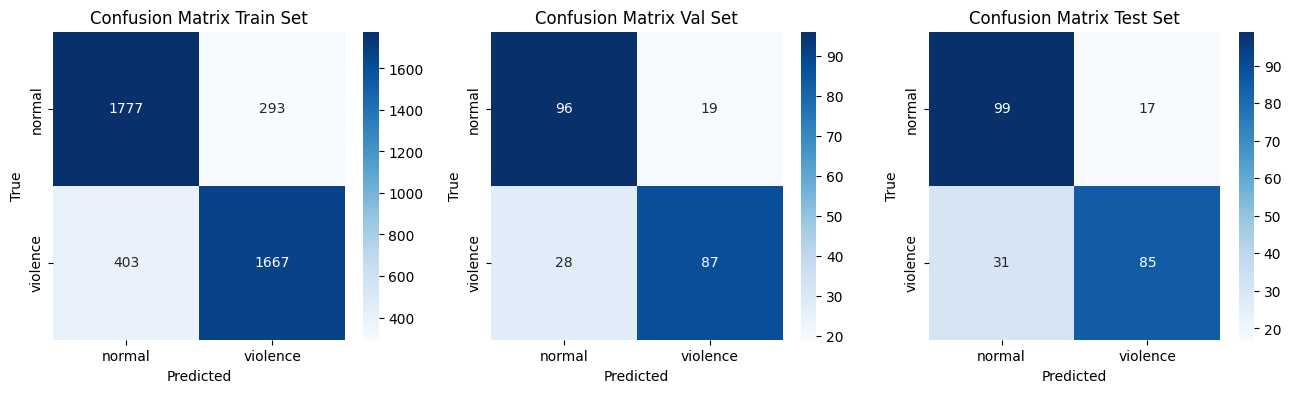

{'quantized': False, 'weight_decay': 0.01, 'dropout': 0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.617200,0.642527,0.678261,0.685033,0.678261,0.675290
2,0.326200,0.511812,0.752174,0.753112,0.752174,0.751944
3,0.457000,0.517875,0.752174,0.754502,0.752174,0.751606
4,0.746100,0.550577,0.760870,0.776088,0.760870,0.757528
5,0.722700,0.512653,0.760870,0.761047,0.760870,0.760829
6,0.326200,0.519811,0.760870,0.763278,0.760870,0.760321
7,0.375000,0.511090,0.773913,0.776928,0.773913,0.773296
8,0.296900,0.510360,0.778261,0.780830,0.778261,0.777753
9,0.482400,0.509205,0.769565,0.770076,0.769565,0.769456
10,0.449200,0.509035,0.765217,0.765539,0.765217,0.765146


Train Set: {'accuracy': 0.8251207729468599, 'precision': 0.8253941559806601, 'recall': 0.8251207729468599, 'f1_score': 0.8225490196078431}
Val Set: {'accuracy': 0.7782608695652173, 'precision': 0.7808302808302807, 'recall': 0.7782608695652173, 'f1_score': 0.7671232876712328}
Test Set: {'accuracy': 0.771551724137931, 'precision': 0.7740157480314961, 'recall': 0.771551724137931, 'f1_score': 0.7601809954751131}


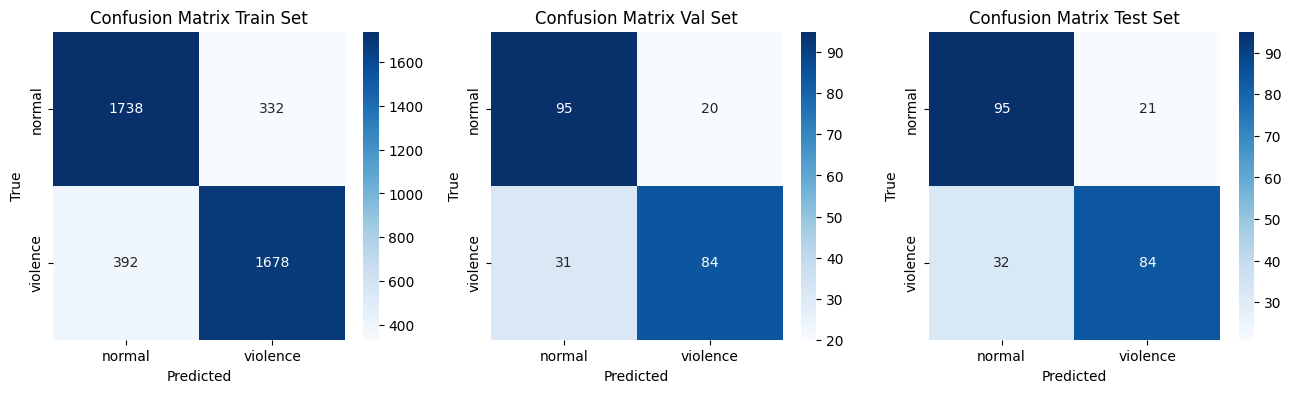

{'quantized': False, 'weight_decay': 0, 'dropout': 0.1}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.601600,0.645346,0.686957,0.689015,0.686957,0.686102
2,0.390600,0.506038,0.760870,0.762477,0.760870,0.760503
3,0.472700,0.507116,0.769565,0.772054,0.769565,0.769037
4,0.976600,0.536973,0.782609,0.793344,0.782609,0.780601
5,0.832000,0.496790,0.769565,0.770076,0.769565,0.769456
6,0.316400,0.507609,0.760870,0.763278,0.760870,0.760321
7,0.316400,0.504195,0.782609,0.783983,0.782609,0.782345
8,0.486300,0.496281,0.773913,0.774661,0.773913,0.773759
9,0.500000,0.499558,0.769565,0.769586,0.769565,0.769561
10,0.562500,0.501562,0.765217,0.765298,0.765217,0.765200


Train Set: {'accuracy': 0.8185990338164251, 'precision': 0.8200421326155253, 'recall': 0.8185990338164251, 'f1_score': 0.8122969257685578}
Val Set: {'accuracy': 0.782608695652174, 'precision': 0.783982980016716, 'recall': 0.782608695652174, 'f1_score': 0.7747747747747747}
Test Set: {'accuracy': 0.8103448275862069, 'precision': 0.813701923076923, 'recall': 0.8103448275862069, 'f1_score': 0.8}


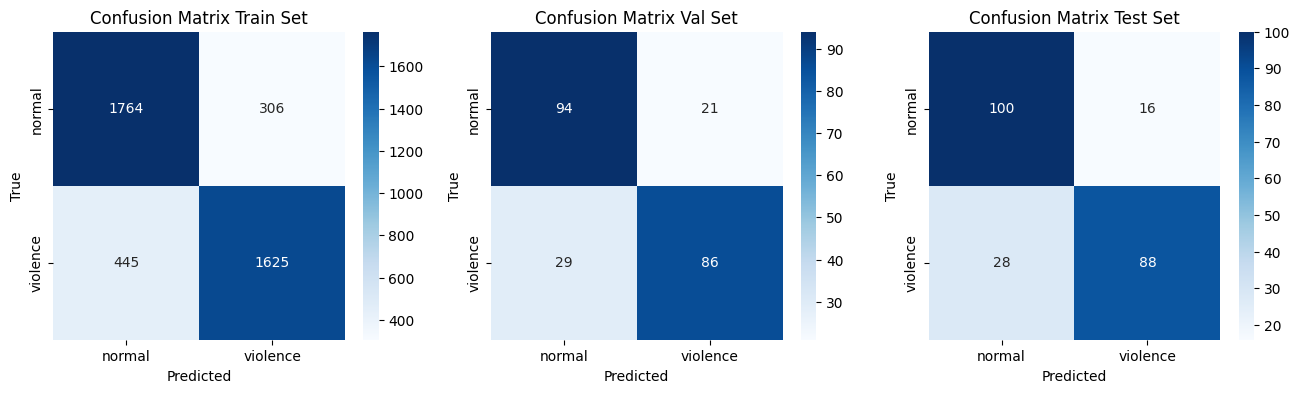

{'quantized': True, 'weight_decay': 0, 'dropout': 0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.625000,0.638859,0.686957,0.697028,0.686957,0.682904
2,0.375000,0.507821,0.734783,0.735227,0.734783,0.734657
3,0.527300,0.523599,0.756522,0.757769,0.756522,0.756227
4,0.816400,0.546196,0.773913,0.780792,0.773913,0.772520
5,0.687500,0.520482,0.769565,0.769749,0.769565,0.769526
6,0.283200,0.531972,0.773913,0.776928,0.773913,0.773296
7,0.324200,0.520533,0.769565,0.771226,0.769565,0.769212
8,0.332000,0.521416,0.769565,0.769749,0.769565,0.769526
9,0.527300,0.524006,0.760870,0.761364,0.760870,0.760757


Train Set: {'accuracy': 0.7983091787439613, 'precision': 0.8039095431483909, 'recall': 0.7983091787439613, 'f1_score': 0.8111287039131418}
Val Set: {'accuracy': 0.7695652173913043, 'precision': 0.7720543345543347, 'recall': 0.7695652173913043, 'f1_score': 0.7800829875518672}
Test Set: {'accuracy': 0.8017241379310345, 'precision': 0.8049879807692308, 'recall': 0.8017241379310345, 'f1_score': 0.8114754098360656}


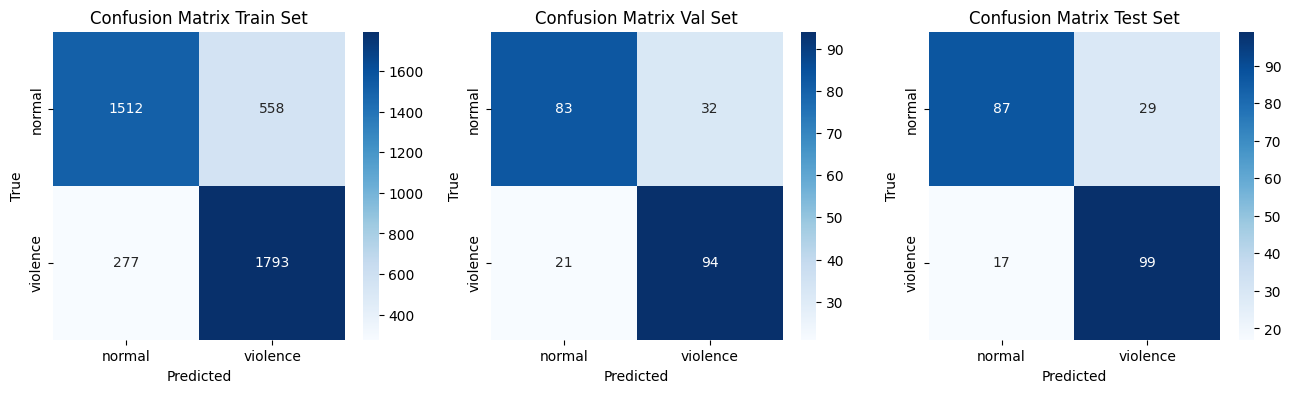

{'quantized': True, 'weight_decay': 0.01, 'dropout': 0.1}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.527300,0.575934,0.695652,0.714392,0.695652,0.688853
2,0.357400,0.493419,0.773913,0.774661,0.773913,0.773759
3,0.474600,0.497554,0.773913,0.775245,0.773913,0.773639
4,0.574200,0.508602,0.769565,0.778864,0.769565,0.767628
5,0.753900,0.485148,0.786957,0.787152,0.786957,0.786920
6,0.294900,0.490268,0.786957,0.786978,0.786957,0.786952
7,0.330100,0.488417,0.778261,0.779296,0.778261,0.778055
8,0.554700,0.484443,0.773913,0.774245,0.773913,0.773845
9,0.406200,0.484664,0.778261,0.778450,0.778261,0.778223


Train Set: {'accuracy': 0.8188405797101449, 'precision': 0.8196788516832395, 'recall': 0.8188405797101449, 'f1_score': 0.8233631653320772}
Val Set: {'accuracy': 0.7869565217391304, 'precision': 0.7869782214156079, 'recall': 0.7869565217391304, 'f1_score': 0.7860262008733624}
Test Set: {'accuracy': 0.8405172413793104, 'precision': 0.8405425492382015, 'recall': 0.8405172413793104, 'f1_score': 0.8412017167381974}


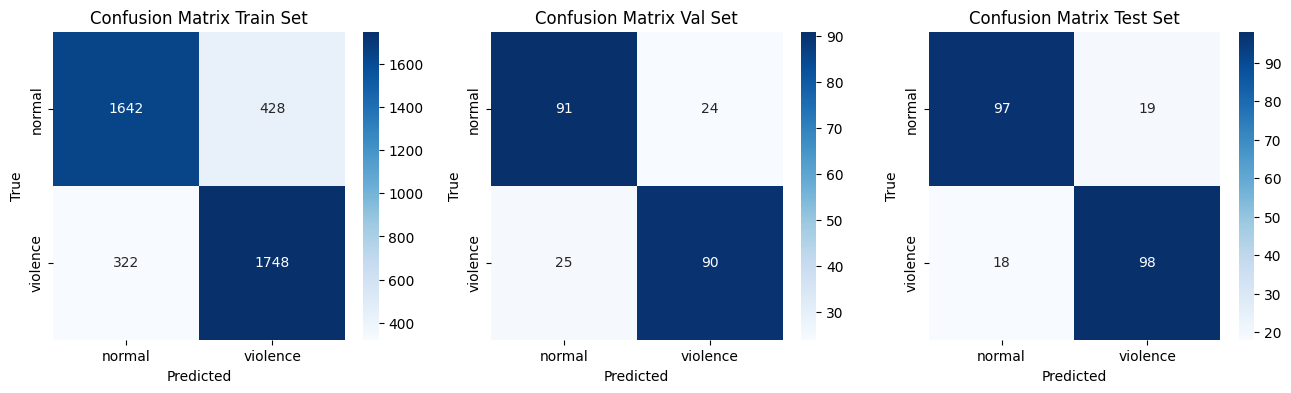

In [ ]:
hyperparameters_list = [{"quantized": False, "weight_decay": 0, "dropout": 0}, {"quantized": False, "weight_decay": 0.01, "dropout": 0},
                        {"quantized": False, "weight_decay": 0, "dropout": 0.1}, {"quantized": True, "weight_decay": 0, "dropout": 0},
                        {"quantized": True, "weight_decay": 0.01, "dropout": 0.1}]
choosen_layers_list = [[6], [11], [6, 11], [5, 6], [9, 10, 11], [5, 6, 11]]
for hyperparameters in hyperparameters_list:
    quantized, weight_decay, dropout = hyperparameters["quantized"], hyperparameters["weight_decay"], hyperparameters["dropout"]
    print(hyperparameters)
    #model
    model_with_lora, model_info = model_class.get_model_with_lora(quantized = quantized, lora_rank = 8, scaling_factor = 32, dropout = dropout, chosen_layers = [6, 11])

    #trainer
    trainer_class = GetTrainer(num_epochs = 10, lr = 1e-4, weight_decay=weight_decay)
    trainer, training_hyperparameters_info = trainer_class.get_trainer(model_with_lora, pytorch_train, pytorch_val)
    trainer.train()

    evaluation_class = EvaluationClass(model_with_lora, device, class_names, tokenizer)
    evaluation_class.set_info(model_info, training_hyperparameters_info)
    evaluation_class.plot_all_matrixes(pytorch_train, pytorch_val, pytorch_test)

## **Experiment 2:** layers to apply LoRA/QLoRA most efficiently

In [ ]:
trainer_class = GetTrainer(num_epochs = 10, lr = 1e-4, weight_decay=0.01)
choosen_layers_list = [[1], [6], [11], [1, 6], [6, 11], [5, 6], [0, 1, 5], [5, 6, 11], [9, 10, 11], [4, 5, 6, 7], [5, 6, 10, 11], [6, 9, 10, 11], [7,8,9,10,11,12], list(range(12))]

for choosen_layers in choosen_layers_list:
    #model
    model_with_lora, model_info = model_class.get_model_with_lora(quantized = True, lora_rank = 8, scaling_factor = 32, dropout = 0.1, chosen_layers = choosen_layers)

    #trainer
    trainer_class = GetTrainer(num_epochs = 10, lr = 1e-4, weight_decay=0.01)
    trainer, training_hyperparameters_info = trainer_class.get_trainer(model_with_lora, pytorch_train, pytorch_val)
    trainer.train()

    #evaluation
    print(model_info)
    print("train set: ", trainer.evaluate(eval_dataset = pytorch_train))
    print("val set: ", trainer.evaluate(eval_dataset = pytorch_val))
    print("test set: ", trainer.evaluate(eval_dataset = pytorch_test))
    # evaluation_class = EvaluationClass(model_with_lora, device, class_names, tokenizer)
    # evaluation_class.set_info(model_info, training_hyperparameters_info)
    # print("\nVal data")
    # evaluation_class.plot_confusion_matrix(val_data)
    # print("\nTest data")
    # evaluation_class.plot_confusion_matrix(test_data)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.574200,0.576766,0.721739,0.733684,0.721739,0.718137
2,0.330100,0.511379,0.773913,0.780792,0.773913,0.772520
3,0.500000,0.514861,0.778261,0.781863,0.778261,0.777550
4,0.675800,0.513995,0.778261,0.784477,0.778261,0.777043
5,0.812500,0.506182,0.786957,0.793367,0.786957,0.785786
6,0.320300,0.498692,0.795652,0.798382,0.795652,0.795184
7,0.289100,0.493444,0.800000,0.804513,0.800000,0.799256
8,0.300800,0.495754,0.791304,0.797055,0.791304,0.790289
9,0.445300,0.491559,0.813043,0.815934,0.813043,0.812615
10,0.562500,0.491780,0.808696,0.812094,0.808696,0.808173


train set:  {'eval_loss': 0.4314236044883728, 'eval_accuracy': 0.8084541062801932, 'eval_precision': 0.8084662724451079, 'eval_recall': 0.8084541062801932, 'eval_f1_score': 0.8084522175794518, 'eval_runtime': 9.1848, 'eval_samples_per_second': 450.744, 'eval_steps_per_second': 28.199, 'epoch': 10.0}
val set:  {'eval_loss': 0.49155911803245544, 'eval_accuracy': 0.8130434782608695, 'eval_precision': 0.8159340659340659, 'eval_recall': 0.8130434782608695, 'eval_f1_score': 0.8126148657610034, 'eval_runtime': 0.5644, 'eval_samples_per_second': 407.48, 'eval_steps_per_second': 26.575, 'epoch': 10.0}
test set:  {'eval_loss': 0.4645406901836395, 'eval_accuracy': 0.7931034482758621, 'eval_precision': 0.795297993411201, 'eval_recall': 0.7931034482758621, 'eval_f1_score': 0.7927183381728836, 'eval_runtime': 0.5988, 'eval_samples_per_second': 387.436, 'eval_steps_per_second': 25.05, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.617200,0.634918,0.660870,0.674371,0.660870,0.654175
2,0.445300,0.517357,0.743478,0.748918,0.743478,0.742069
3,0.386700,0.495397,0.756522,0.757222,0.756522,0.756356
4,0.718800,0.505910,0.778261,0.784477,0.778261,0.777043
5,0.625000,0.505978,0.773913,0.776000,0.773913,0.773485
6,0.392600,0.501639,0.760870,0.761364,0.760870,0.760757
7,0.494100,0.501282,0.765217,0.767238,0.765217,0.764773


train set:  {'eval_loss': 0.46212634444236755, 'eval_accuracy': 0.7905797101449276, 'eval_precision': 0.796603638745794, 'eval_recall': 0.7905797101449276, 'eval_f1_score': 0.7895109682848485, 'eval_runtime': 9.3124, 'eval_samples_per_second': 444.57, 'eval_steps_per_second': 27.813, 'epoch': 7.0}
val set:  {'eval_loss': 0.505910336971283, 'eval_accuracy': 0.7782608695652173, 'eval_precision': 0.7844774273345702, 'eval_recall': 0.7782608695652173, 'eval_f1_score': 0.777042823744084, 'eval_runtime': 0.5539, 'eval_samples_per_second': 415.215, 'eval_steps_per_second': 27.079, 'epoch': 7.0}


test set:  {'eval_loss': 0.4474676847457886, 'eval_accuracy': 0.7974137931034483, 'eval_precision': 0.8074913561275452, 'eval_recall': 0.7974137931034483, 'eval_f1_score': 0.7957402169229905, 'eval_runtime': 0.5596, 'eval_samples_per_second': 414.546, 'eval_steps_per_second': 26.803, 'epoch': 7.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.636700,0.652717,0.682609,0.682733,0.682609,0.682555
2,0.519500,0.523743,0.734783,0.735227,0.734783,0.734657
3,0.550800,0.512704,0.747826,0.747901,0.747826,0.747807
4,0.632800,0.502836,0.778261,0.779976,0.778261,0.777921
5,0.679700,0.499287,0.786957,0.787500,0.786957,0.786856
6,0.398400,0.503040,0.765217,0.765539,0.765217,0.765146
7,0.433600,0.496637,0.786957,0.787500,0.786957,0.786856
8,0.531200,0.492799,0.786957,0.787152,0.786957,0.786920
9,0.421900,0.494073,0.773913,0.773913,0.773913,0.773913
10,0.671900,0.493037,0.773913,0.773913,0.773913,0.773913


train set:  {'eval_loss': 0.4550328254699707, 'eval_accuracy': 0.7963768115942029, 'eval_precision': 0.7963885014018383, 'eval_recall': 0.7963768115942029, 'eval_f1_score': 0.7963748038076643, 'eval_runtime': 9.2085, 'eval_samples_per_second': 449.583, 'eval_steps_per_second': 28.126, 'epoch': 10.0}
val set:  {'eval_loss': 0.49279892444610596, 'eval_accuracy': 0.7869565217391304, 'eval_precision': 0.7871519370460048, 'eval_recall': 0.7869565217391304, 'eval_f1_score': 0.786920269989223, 'eval_runtime': 0.5625, 'eval_samples_per_second': 408.864, 'eval_steps_per_second': 26.665, 'epoch': 10.0}


test set:  {'eval_loss': 0.45760372281074524, 'eval_accuracy': 0.7974137931034483, 'eval_precision': 0.7974358974358975, 'eval_recall': 0.7974137931034483, 'eval_f1_score': 0.7974100291696857, 'eval_runtime': 0.6055, 'eval_samples_per_second': 383.13, 'eval_steps_per_second': 24.771, 'epoch': 10.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.574200,0.589029,0.652174,0.681159,0.652174,0.637681
2,0.312500,0.495160,0.769565,0.773055,0.769565,0.768827
3,0.511700,0.494081,0.773913,0.778034,0.773913,0.773072
4,0.605500,0.548285,0.778261,0.792063,0.778261,0.775610
5,0.621100,0.488010,0.765217,0.765539,0.765217,0.765146
6,0.279300,0.479908,0.773913,0.774245,0.773913,0.773845
7,0.345700,0.491389,0.778261,0.786070,0.778261,0.776737
8,0.337900,0.473590,0.782609,0.783983,0.782609,0.782345
9,0.396500,0.471603,0.782609,0.783983,0.782609,0.782345
10,0.494100,0.470941,0.786957,0.787152,0.786957,0.786920


train set:  {'eval_loss': 0.36468902230262756, 'eval_accuracy': 0.8463768115942029, 'eval_precision': 0.8465194661108122, 'eval_recall': 0.8463768115942029, 'eval_f1_score': 0.8463609991366472, 'eval_runtime': 9.3255, 'eval_samples_per_second': 443.944, 'eval_steps_per_second': 27.773, 'epoch': 10.0}
val set:  {'eval_loss': 0.47094088792800903, 'eval_accuracy': 0.7869565217391304, 'eval_precision': 0.7871519370460048, 'eval_recall': 0.7869565217391304, 'eval_f1_score': 0.786920269989223, 'eval_runtime': 0.6312, 'eval_samples_per_second': 364.372, 'eval_steps_per_second': 23.763, 'epoch': 10.0}
test set:  {'eval_loss': 0.3992120027542114, 'eval_accuracy': 0.8146551724137931, 'eval_precision': 0.8152408606954061, 'eval_recall': 0.8146551724137931, 'eval_f1_score': 0.8145690440342758, 'eval_runtime': 0.5603, 'eval_samples_per_second': 414.07, 'eval_steps_per_second': 26.772, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.597700,0.607507,0.643478,0.684062,0.643478,0.622679
2,0.414100,0.503363,0.769565,0.772054,0.769565,0.769037
3,0.375000,0.502191,0.778261,0.783077,0.778261,0.777314
4,0.761700,0.532846,0.778261,0.786070,0.778261,0.776737
5,0.683600,0.501919,0.791304,0.792099,0.791304,0.791162
6,0.406200,0.502972,0.773913,0.774245,0.773913,0.773845
7,0.283200,0.499134,0.791304,0.792099,0.791304,0.791162
8,0.269500,0.492527,0.782609,0.782694,0.782609,0.782592


train set:  {'eval_loss': 0.40935611724853516, 'eval_accuracy': 0.8227053140096618, 'eval_precision': 0.8228511843667143, 'eval_recall': 0.8227053140096618, 'eval_f1_score': 0.8226852854624761, 'eval_runtime': 9.3811, 'eval_samples_per_second': 441.314, 'eval_steps_per_second': 27.609, 'epoch': 8.0}
val set:  {'eval_loss': 0.501919150352478, 'eval_accuracy': 0.7913043478260869, 'eval_precision': 0.7920994768367579, 'eval_recall': 0.7913043478260869, 'eval_f1_score': 0.7911622276029056, 'eval_runtime': 0.581, 'eval_samples_per_second': 395.901, 'eval_steps_per_second': 25.82, 'epoch': 8.0}
test set:  {'eval_loss': 0.40183863043785095, 'eval_accuracy': 0.7974137931034483, 'eval_precision': 0.7979673888764798, 'eval_recall': 0.7974137931034483, 'eval_f1_score': 0.7973196527816502, 'eval_runtime': 0.5747, 'eval_samples_per_second': 403.705, 'eval_steps_per_second': 26.102, 'epoch': 8.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.585900,0.641508,0.686957,0.722567,0.686957,0.673913
2,0.390600,0.497588,0.752174,0.752652,0.752174,0.752057
3,0.593800,0.487466,0.765217,0.768137,0.765217,0.764577
4,0.808600,0.509443,0.773913,0.782456,0.773913,0.772190
5,0.769500,0.485190,0.773913,0.774661,0.773913,0.773759
6,0.253900,0.481547,0.786957,0.787500,0.786957,0.786856
7,0.482400,0.478142,0.791304,0.792099,0.791304,0.791162
8,0.351600,0.473641,0.786957,0.788024,0.786957,0.786759
9,0.396500,0.472936,0.782609,0.782609,0.782609,0.782609
10,0.566400,0.472801,0.782609,0.782609,0.782609,0.782609


train set:  {'eval_loss': 0.3874528110027313, 'eval_accuracy': 0.8309178743961353, 'eval_precision': 0.8319603394074697, 'eval_recall': 0.8309178743961353, 'eval_f1_score': 0.8307850266820132, 'eval_runtime': 9.3616, 'eval_samples_per_second': 442.233, 'eval_steps_per_second': 27.666, 'epoch': 10.0}
val set:  {'eval_loss': 0.47814199328422546, 'eval_accuracy': 0.7913043478260869, 'eval_precision': 0.7920994768367579, 'eval_recall': 0.7913043478260869, 'eval_f1_score': 0.7911622276029056, 'eval_runtime': 0.5626, 'eval_samples_per_second': 408.819, 'eval_steps_per_second': 26.662, 'epoch': 10.0}
test set:  {'eval_loss': 0.42628636956214905, 'eval_accuracy': 0.8232758620689655, 'eval_precision': 0.8252336448598131, 'eval_recall': 0.8232758620689655, 'eval_f1_score': 0.8230095082150233, 'eval_runtime': 0.5753, 'eval_samples_per_second': 403.254, 'eval_steps_per_second': 26.072, 'epoch': 10.0}


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.386700,0.529738,0.700000,0.711668,0.700000,0.695808
2,0.318400,0.494192,0.773913,0.776928,0.773913,0.773296
3,0.621100,0.504136,0.782609,0.784762,0.782609,0.782197
4,0.793000,0.534103,0.773913,0.788668,0.773913,0.770987
5,0.652300,0.486413,0.800000,0.802286,0.800000,0.799621
6,0.322300,0.477412,0.778261,0.779296,0.778261,0.778055
7,0.148400,0.474490,0.821739,0.828927,0.821739,0.820760
8,0.221700,0.464844,0.808696,0.809538,0.808696,0.808565
9,0.365200,0.462551,0.826087,0.826977,0.826087,0.825969
10,0.543000,0.463791,0.808696,0.808789,0.808696,0.808681


train set:  {'eval_loss': 0.2916662096977234, 'eval_accuracy': 0.8814009661835749, 'eval_precision': 0.8814331016709148, 'eval_recall': 0.8814009661835749, 'eval_f1_score': 0.8813984681583587, 'eval_runtime': 9.4488, 'eval_samples_per_second': 438.152, 'eval_steps_per_second': 27.411, 'epoch': 10.0}
val set:  {'eval_loss': 0.46255093812942505, 'eval_accuracy': 0.8260869565217391, 'eval_precision': 0.8269770263098035, 'eval_recall': 0.8260869565217391, 'eval_f1_score': 0.8259685230024213, 'eval_runtime': 0.5678, 'eval_samples_per_second': 405.069, 'eval_steps_per_second': 26.418, 'epoch': 10.0}


test set:  {'eval_loss': 0.3926454782485962, 'eval_accuracy': 0.8405172413793104, 'eval_precision': 0.8436070491188601, 'eval_recall': 0.8405172413793104, 'eval_f1_score': 0.8401579055173827, 'eval_runtime': 0.5646, 'eval_samples_per_second': 410.899, 'eval_steps_per_second': 26.567, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.531200,0.586311,0.639130,0.688834,0.639130,0.613711
2,0.361300,0.500042,0.786957,0.793367,0.786957,0.785786
3,0.398400,0.495652,0.765217,0.767238,0.765217,0.764773
4,0.742200,0.542867,0.769565,0.782937,0.769565,0.766810
5,0.462900,0.488324,0.782609,0.783380,0.782609,0.782461


train set:  {'eval_loss': 0.4560556411743164, 'eval_accuracy': 0.7920289855072464, 'eval_precision': 0.7979166086339784, 'eval_recall': 0.7920289855072464, 'eval_f1_score': 0.7909963688481898, 'eval_runtime': 9.5539, 'eval_samples_per_second': 433.33, 'eval_steps_per_second': 27.109, 'epoch': 5.0}
val set:  {'eval_loss': 0.5000424385070801, 'eval_accuracy': 0.7869565217391304, 'eval_precision': 0.7933673469387755, 'eval_recall': 0.7869565217391304, 'eval_f1_score': 0.7857862424207864, 'eval_runtime': 0.5675, 'eval_samples_per_second': 405.319, 'eval_steps_per_second': 26.434, 'epoch': 5.0}


test set:  {'eval_loss': 0.4443696141242981, 'eval_accuracy': 0.8017241379310345, 'eval_precision': 0.812981806968856, 'eval_recall': 0.8017241379310345, 'eval_f1_score': 0.7999250093738283, 'eval_runtime': 0.5784, 'eval_samples_per_second': 401.122, 'eval_steps_per_second': 25.935, 'epoch': 5.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.621100,0.625866,0.626087,0.700300,0.626087,0.587917
2,0.281200,0.524389,0.739130,0.740952,0.739130,0.738636
3,0.457000,0.529874,0.752174,0.754502,0.752174,0.751606
4,0.566400,0.540829,0.760870,0.771739,0.760870,0.758454
5,0.835900,0.511396,0.765217,0.765298,0.765217,0.765200
6,0.441400,0.528821,0.756522,0.757222,0.756522,0.756356
7,0.269500,0.514827,0.769565,0.771226,0.769565,0.769212
8,0.324200,0.511158,0.782609,0.783380,0.782609,0.782461
9,0.585900,0.517120,0.769565,0.769749,0.769565,0.769526
10,0.617200,0.516440,0.765217,0.765298,0.765217,0.765200


train set:  {'eval_loss': 0.3817746043205261, 'eval_accuracy': 0.8345410628019324, 'eval_precision': 0.8350290359666428, 'eval_recall': 0.8345410628019324, 'eval_f1_score': 0.8344807927038709, 'eval_runtime': 9.5747, 'eval_samples_per_second': 432.389, 'eval_steps_per_second': 27.05, 'epoch': 10.0}
val set:  {'eval_loss': 0.511158287525177, 'eval_accuracy': 0.782608695652174, 'eval_precision': 0.7833800894684965, 'eval_recall': 0.782608695652174, 'eval_f1_score': 0.7824606537530266, 'eval_runtime': 0.5943, 'eval_samples_per_second': 386.984, 'eval_steps_per_second': 25.238, 'epoch': 10.0}


test set:  {'eval_loss': 0.45373114943504333, 'eval_accuracy': 0.7887931034482759, 'eval_precision': 0.7914135733033372, 'eval_recall': 0.7887931034482759, 'eval_f1_score': 0.788317226225723, 'eval_runtime': 0.6007, 'eval_samples_per_second': 386.212, 'eval_steps_per_second': 24.971, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.445300,0.534333,0.704348,0.717225,0.704348,0.699900
2,0.279300,0.509918,0.791304,0.798620,0.791304,0.790018
3,0.601600,0.512908,0.800000,0.805922,0.800000,0.799027
4,0.656200,0.543495,0.786957,0.801190,0.786957,0.784409
5,0.707000,0.490880,0.800000,0.801459,0.800000,0.799758
6,0.384800,0.487814,0.795652,0.795675,0.795652,0.795648
7,0.275400,0.498556,0.804348,0.811147,0.804348,0.803273
8,0.168900,0.477879,0.804348,0.806223,0.804348,0.804048
9,0.334000,0.472919,0.808696,0.810197,0.808696,0.808464
10,0.699200,0.471985,0.813043,0.813636,0.813043,0.812955


train set:  {'eval_loss': 0.3311103582382202, 'eval_accuracy': 0.8613526570048309, 'eval_precision': 0.8613556929694851, 'eval_recall': 0.8613526570048309, 'eval_f1_score': 0.8613523657894682, 'eval_runtime': 9.7095, 'eval_samples_per_second': 426.387, 'eval_steps_per_second': 26.675, 'epoch': 10.0}
val set:  {'eval_loss': 0.471985399723053, 'eval_accuracy': 0.8130434782608695, 'eval_precision': 0.8136363636363636, 'eval_recall': 0.8130434782608695, 'eval_f1_score': 0.8129550827423168, 'eval_runtime': 0.5758, 'eval_samples_per_second': 399.467, 'eval_steps_per_second': 26.052, 'epoch': 10.0}


test set:  {'eval_loss': 0.3925107717514038, 'eval_accuracy': 0.8318965517241379, 'eval_precision': 0.8339065420560747, 'eval_recall': 0.8318965517241379, 'eval_f1_score': 0.8316431907411198, 'eval_runtime': 0.6042, 'eval_samples_per_second': 383.973, 'eval_steps_per_second': 24.826, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.435500,0.553431,0.660870,0.678347,0.660870,0.652353
2,0.355500,0.500238,0.778261,0.783077,0.778261,0.777314
3,0.535200,0.492943,0.773913,0.778034,0.773913,0.773072
4,0.730500,0.508662,0.782609,0.793344,0.782609,0.780601
5,0.671900,0.476376,0.778261,0.778450,0.778261,0.778223
6,0.341800,0.475594,0.778261,0.778282,0.778261,0.778257
7,0.271500,0.481182,0.804348,0.809615,0.804348,0.803512
8,0.247100,0.469124,0.800000,0.800819,0.800000,0.799864
9,0.248000,0.461872,0.808696,0.809538,0.808696,0.808565
10,0.738300,0.463315,0.808696,0.809538,0.808696,0.808565


train set:  {'eval_loss': 0.3360978960990906, 'eval_accuracy': 0.8538647342995169, 'eval_precision': 0.8540174982740107, 'eval_recall': 0.8538647342995169, 'eval_f1_score': 0.8538489676971033, 'eval_runtime': 9.5543, 'eval_samples_per_second': 433.314, 'eval_steps_per_second': 27.108, 'epoch': 10.0}
val set:  {'eval_loss': 0.46187159419059753, 'eval_accuracy': 0.808695652173913, 'eval_precision': 0.8095382515732809, 'eval_recall': 0.808695652173913, 'eval_f1_score': 0.8085653753026635, 'eval_runtime': 0.5793, 'eval_samples_per_second': 397.018, 'eval_steps_per_second': 25.892, 'epoch': 10.0}


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


test set:  {'eval_loss': 0.37183457612991333, 'eval_accuracy': 0.8577586206896551, 'eval_precision': 0.8584245402427221, 'eval_recall': 0.8577586206896551, 'eval_f1_score': 0.8576925221658395, 'eval_runtime': 0.6133, 'eval_samples_per_second': 378.255, 'eval_steps_per_second': 24.456, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.457000,0.586940,0.621739,0.678889,0.621739,0.588906
2,0.418000,0.493665,0.778261,0.786070,0.778261,0.776737
3,0.503900,0.492510,0.786957,0.789606,0.786957,0.786468
4,0.585900,0.507796,0.778261,0.789855,0.778261,0.776021
5,0.847700,0.480121,0.795652,0.795675,0.795652,0.795648
6,0.390600,0.487347,0.778261,0.778450,0.778261,0.778223
7,0.205100,0.491355,0.795652,0.798382,0.795652,0.795184
8,0.337900,0.482354,0.782609,0.782694,0.782609,0.782592


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

train set:  {'eval_loss': 0.3855346143245697, 'eval_accuracy': 0.8301932367149758, 'eval_precision': 0.8302025612056071, 'eval_recall': 0.8301932367149758, 'eval_f1_score': 0.8301920379260069, 'eval_runtime': 9.7344, 'eval_samples_per_second': 425.298, 'eval_steps_per_second': 26.607, 'epoch': 8.0}
val set:  {'eval_loss': 0.48012056946754456, 'eval_accuracy': 0.7956521739130434, 'eval_precision': 0.795674531155475, 'eval_recall': 0.7956521739130434, 'eval_f1_score': 0.7956483109321536, 'eval_runtime': 0.5909, 'eval_samples_per_second': 389.23, 'eval_steps_per_second': 25.385, 'epoch': 8.0}


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


test set:  {'eval_loss': 0.3947333097457886, 'eval_accuracy': 0.7974137931034483, 'eval_precision': 0.7985007831729694, 'eval_recall': 0.7974137931034483, 'eval_f1_score': 0.7972291957229195, 'eval_runtime': 0.6003, 'eval_samples_per_second': 386.493, 'eval_steps_per_second': 24.989, 'epoch': 8.0}


`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'en

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.550800,0.609851,0.634783,0.730030,0.634783,0.592611
2,0.291000,0.495032,0.773913,0.778034,0.773913,0.773072
3,0.455100,0.494879,0.765217,0.766507,0.765217,0.764933
4,0.789100,0.528117,0.778261,0.792063,0.778261,0.775610
5,1.109400,0.471034,0.795652,0.797474,0.795652,0.795339
6,0.242200,0.473225,0.769565,0.774231,0.769565,0.768581
7,0.255900,0.471867,0.804348,0.811147,0.804348,0.803273
8,0.457000,0.449083,0.808696,0.808789,0.808696,0.808681
9,0.523400,0.451248,0.800000,0.800819,0.800000,0.799864
10,0.722700,0.455044,0.800000,0.800819,0.800000,0.799864


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

train set:  {'eval_loss': 0.3255566954612732, 'eval_accuracy': 0.8635265700483091, 'eval_precision': 0.863545659822507, 'eval_recall': 0.8635265700483091, 'eval_f1_score': 0.8635247784706269, 'eval_runtime': 9.7508, 'eval_samples_per_second': 424.581, 'eval_steps_per_second': 26.562, 'epoch': 10.0}
val set:  {'eval_loss': 0.4490828812122345, 'eval_accuracy': 0.808695652173913, 'eval_precision': 0.8087890477271008, 'eval_recall': 0.808695652173913, 'eval_f1_score': 0.808681185722928, 'eval_runtime': 0.594, 'eval_samples_per_second': 387.22, 'eval_steps_per_second': 25.253, 'epoch': 10.0}
test set:  {'eval_loss': 0.3790746331214905, 'eval_accuracy': 0.8362068965517241, 'eval_precision': 0.8371087928464978, 'eval_recall': 0.8362068965517241, 'eval_f1_score': 0.8360972707667137, 'eval_runtime': 0.5992, 'eval_samples_per_second': 387.187, 'eval_steps_per_second': 25.034, 'epoch': 10.0}


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.314500,0.480197,0.760870,0.766698,0.760870,0.759556
2,0.259800,0.501495,0.778261,0.792063,0.778261,0.775610
3,0.386700,0.504823,0.791304,0.792721,0.791304,0.791052
4,0.652300,0.506912,0.800000,0.804513,0.800000,0.799256
5,0.222700,0.475323,0.821739,0.822348,0.821739,0.821655
6,0.462900,0.479823,0.821739,0.821763,0.821739,0.821736
7,0.137700,0.485632,0.839130,0.848647,0.839130,0.838025
8,0.337900,0.485836,0.821739,0.822936,0.821739,0.821574
9,0.063000,0.460394,0.856522,0.858719,0.856522,0.856302
10,0.106900,0.467086,0.834783,0.835188,0.834783,0.834733


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

train set:  {'eval_loss': 0.18125754594802856, 'eval_accuracy': 0.9359903381642513, 'eval_precision': 0.9365332412991862, 'eval_recall': 0.9359903381642513, 'eval_f1_score': 0.9359704302564142, 'eval_runtime': 10.9317, 'eval_samples_per_second': 378.716, 'eval_steps_per_second': 23.693, 'epoch': 10.0}
val set:  {'eval_loss': 0.460394024848938, 'eval_accuracy': 0.8565217391304348, 'eval_precision': 0.8587188070602557, 'eval_recall': 0.8565217391304348, 'eval_f1_score': 0.8563017096120713, 'eval_runtime': 0.6517, 'eval_samples_per_second': 352.944, 'eval_steps_per_second': 23.018, 'epoch': 10.0}
test set:  {'eval_loss': 0.38451308012008667, 'eval_accuracy': 0.8663793103448276, 'eval_precision': 0.8685981308411215, 'eval_recall': 0.8663793103448276, 'eval_f1_score': 0.8661779208455055, 'eval_runtime': 0.6829, 'eval_samples_per_second': 339.728, 'eval_steps_per_second': 21.965, 'epoch': 10.0}


## **Experiment 3** lora rank / scaling factor

In [ ]:
trainer_class = GetTrainer(num_epochs = 10, lr = 1e-4, weight_decay=0.01)
lora_list = [{"lora_rank": 4, "scaling_factor":8}, {"lora_rank": 4, "scaling_factor":12}, {"lora_rank": 4, "scaling_factor":16},
             {"lora_rank": 4, "scaling_factor":20}, {"lora_rank": 8, "scaling_factor":16}, {"lora_rank": 8, "scaling_factor":24},
             {"lora_rank": 8, "scaling_factor": 32}, {"lora_rank": 8, "scaling_factor":40}, {"lora_rank": 16, "scaling_factor":32},
             {"lora_rank": 16, "scaling_factor":48}, {"lora_rank": 16, "scaling_factor":64}, {"lora_rank": 16, "scaling_factor":80}]

chosen_layers = list(range(12))
for lora in lora_list:
    lora_rank, scaling_factor = lora["lora_rank"], lora["scaling_factor"]
    #model
    model_with_lora, model_info = model_class.get_model_with_lora(quantized = True, lora_rank = lora_rank, scaling_factor = scaling_factor, dropout = 0.1, chosen_layers = choosen_layers)

    #trainer
    trainer_class = GetTrainer(num_epochs = 10, lr = 1e-4, weight_decay=0.01)
    trainer, training_hyperparameters_info = trainer_class.get_trainer(model_with_lora, pytorch_train, pytorch_val)
    trainer.train()

    #evaluation
    print(model_info, training_hyperparameters_info)
    print("train set: ", trainer.evaluate(eval_dataset = pytorch_train))
    print("val set: ", trainer.evaluate(eval_dataset = pytorch_val))
    print("test set: ", trainer.evaluate(eval_dataset = pytorch_test))

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.574200,0.602072,0.639130,0.717391,0.639130,0.603440
2,0.287100,0.491644,0.773913,0.782456,0.773913,0.772190
3,0.339800,0.502921,0.760870,0.768190,0.760870,0.759226
4,0.871100,0.579535,0.765217,0.790621,0.765217,0.759972
5,0.447300,0.481403,0.808696,0.809070,0.808696,0.808638
6,0.486300,0.484502,0.795652,0.796212,0.795652,0.795556
7,0.279300,0.517527,0.800000,0.811396,0.800000,0.798153
8,0.316400,0.482931,0.795652,0.795854,0.795652,0.795617


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

model is quantized 
lora_rank: 4, scaling_factor: 8, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 148994
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.3487875461578369, 'eval_accuracy': 0.8536231884057971, 'eval_precision': 0.8536879020082556, 'eval_recall': 0.8536231884057971, 'eval_f1_score': 0.8536164925278384, 'eval_runtime': 10.7678, 'eval_samples_per_second': 384.478, 'eval_steps_per_second': 24.053, 'epoch': 8.0}
val set:  {'eval_loss': 0.48140284419059753, 'eval_accuracy': 0.808695652173913, 'eval_precision': 0.8090695737754562, 'eval_recall': 0.808695652173913, 'eval_f1_score': 0.8086377732395432, 'eval_runtime': 0.6449, 'eval_samples_per_second': 356.629, 'eval_steps_per_second': 23.258, 'epoch': 8.0}
test set:  {'eval_loss': 0.3721039891242981, 'eval_accuracy': 0.8017241379310345, 'eval_precision': 0.8039832285115304, 'eval_recall': 0.8017241379310345, 'eval_f1_score': 0.8013550740823467, 'eval_runtime': 0.662, 'eval_samples_per_second': 350.45, 'eval_steps_per_second': 22.658, 'epoch': 8.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.605500,0.616253,0.639130,0.710623,0.639130,0.605668
2,0.300800,0.525255,0.756522,0.770340,0.756522,0.753370
3,0.652300,0.506743,0.778261,0.781863,0.778261,0.777550
4,0.835900,0.573404,0.760870,0.784278,0.760870,0.755843
5,0.648400,0.493495,0.800000,0.800363,0.800000,0.799939
6,0.189500,0.514487,0.791304,0.794511,0.791304,0.790735
7,0.140600,0.509324,0.800000,0.801459,0.800000,0.799758
8,0.302700,0.507252,0.808696,0.810197,0.808696,0.808464
9,0.636700,0.505808,0.804348,0.804555,0.804348,0.804315
10,0.605500,0.509986,0.808696,0.810197,0.808696,0.808464


model is quantized 
lora_rank: 4, scaling_factor: 12, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 148994
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.2714489996433258, 'eval_accuracy': 0.8922705314009662, 'eval_precision': 0.8938721623741996, 'eval_recall': 0.8922705314009662, 'eval_f1_score': 0.8921609029132745, 'eval_runtime': 10.9439, 'eval_samples_per_second': 378.294, 'eval_steps_per_second': 23.666, 'epoch': 10.0}
val set:  {'eval_loss': 0.507252037525177, 'eval_accuracy': 0.808695652173913, 'eval_precision': 0.8101967935567206, 'eval_recall': 0.808695652173913, 'eval_f1_score': 0.8084639261109849, 'eval_runtime': 0.6551, 'eval_samples_per_second': 351.094, 'eval_steps_per_second': 22.897, 'epoch': 10.0}


test set:  {'eval_loss': 0.35302734375, 'eval_accuracy': 0.8706896551724138, 'eval_precision': 0.8706896551724138, 'eval_recall': 0.8706896551724138, 'eval_f1_score': 0.8706896551724138, 'eval_runtime': 0.6539, 'eval_samples_per_second': 354.792, 'eval_steps_per_second': 22.939, 'epoch': 10.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.380900,0.492035,0.747826,0.750554,0.747826,0.747138
2,0.293000,0.496399,0.773913,0.784318,0.773913,0.771825
3,0.314500,0.503346,0.782609,0.785720,0.782609,0.782015
4,0.882800,0.571535,0.769565,0.790688,0.769565,0.765302
5,0.355500,0.481760,0.795652,0.796752,0.795652,0.795463
6,0.466800,0.479603,0.800000,0.802286,0.800000,0.799621
7,0.216800,0.498641,0.821739,0.832838,0.821739,0.820241
8,0.373000,0.482906,0.813043,0.813636,0.813043,0.812955
9,0.139600,0.478643,0.839130,0.840392,0.839130,0.838981
10,0.235400,0.479721,0.821739,0.821958,0.821739,0.821709


model is quantized 
lora_rank: 4, scaling_factor: 16, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 148994
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.24535684287548065, 'eval_accuracy': 0.9038647342995169, 'eval_precision': 0.9043271028037383, 'eval_recall': 0.9038647342995169, 'eval_f1_score': 0.9038372425545821, 'eval_runtime': 10.8536, 'eval_samples_per_second': 381.439, 'eval_steps_per_second': 23.863, 'epoch': 10.0}
val set:  {'eval_loss': 0.478643000125885, 'eval_accuracy': 0.8391304347826087, 'eval_precision': 0.8403916211293261, 'eval_recall': 0.8391304347826087, 'eval_f1_score': 0.8389812870144366, 'eval_runtime': 0.7235, 'eval_samples_per_second': 317.915, 'eval_steps_per_second': 20.734, 'epoch': 10.0}


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


test set:  {'eval_loss': 0.3585836589336395, 'eval_accuracy': 0.853448275862069, 'eval_precision': 0.8560946391135071, 'eval_recall': 0.853448275862069, 'eval_f1_score': 0.8531754895391259, 'eval_runtime': 0.6661, 'eval_samples_per_second': 348.28, 'eval_steps_per_second': 22.518, 'epoch': 10.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.357400,0.487780,0.743478,0.744979,0.743478,0.743085
2,0.291000,0.496688,0.773913,0.784318,0.773913,0.771825
3,0.312500,0.507609,0.786957,0.790671,0.786957,0.786274
4,0.882800,0.565285,0.778261,0.800065,0.778261,0.774158
5,0.337900,0.480367,0.800000,0.800819,0.800000,0.799864
6,0.445300,0.475535,0.795652,0.797474,0.795652,0.795339
7,0.196300,0.491559,0.821739,0.830768,0.821739,0.820514
8,0.377000,0.478303,0.817391,0.817776,0.817391,0.817336
9,0.112800,0.475433,0.852174,0.853135,0.852174,0.852073
10,0.162100,0.477123,0.830435,0.830660,0.830435,0.830406


model is quantized 
lora_rank: 4, scaling_factor: 20, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 148994
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.22624711692333221, 'eval_accuracy': 0.9135265700483092, 'eval_precision': 0.9140847519258615, 'eval_recall': 0.9135265700483092, 'eval_f1_score': 0.9134974189066026, 'eval_runtime': 10.9929, 'eval_samples_per_second': 376.606, 'eval_steps_per_second': 23.561, 'epoch': 10.0}
val set:  {'eval_loss': 0.4754330813884735, 'eval_accuracy': 0.8521739130434782, 'eval_precision': 0.8531351884145879, 'eval_recall': 0.8521739130434782, 'eval_f1_score': 0.8520732445520581, 'eval_runtime': 0.6773, 'eval_samples_per_second': 339.583, 'eval_steps_per_second': 22.147, 'epoch': 10.0}


test set:  {'eval_loss': 0.36449354887008667, 'eval_accuracy': 0.8577586206896551, 'eval_precision': 0.8590661594689343, 'eval_recall': 0.8577586206896551, 'eval_f1_score': 0.857629009762901, 'eval_runtime': 0.6475, 'eval_samples_per_second': 358.311, 'eval_steps_per_second': 23.167, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.367200,0.497767,0.739130,0.741763,0.739130,0.738418
2,0.263700,0.495007,0.778261,0.787860,0.778261,0.776397
3,0.375000,0.507456,0.782609,0.785720,0.782609,0.782015
4,0.765600,0.541338,0.778261,0.789855,0.778261,0.776021
5,0.320300,0.477429,0.808696,0.809538,0.808696,0.808565
6,0.500000,0.490404,0.817391,0.818258,0.817391,0.817267
7,0.238300,0.505163,0.817391,0.827290,0.817391,0.816000
8,0.318400,0.489929,0.817391,0.818258,0.817391,0.817267
9,0.110400,0.473123,0.821739,0.822348,0.821739,0.821655
10,0.210900,0.480104,0.834783,0.834884,0.834783,0.834770


model is quantized 
lora_rank: 8, scaling_factor: 16, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 296450
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.23957625031471252, 'eval_accuracy': 0.9096618357487922, 'eval_precision': 0.9098305540613233, 'eval_recall': 0.9096618357487922, 'eval_f1_score': 0.9096525372281541, 'eval_runtime': 10.7968, 'eval_samples_per_second': 383.445, 'eval_steps_per_second': 23.988, 'epoch': 10.0}
val set:  {'eval_loss': 0.48010361194610596, 'eval_accuracy': 0.8347826086956521, 'eval_precision': 0.8348838968307996, 'eval_recall': 0.8347826086956521, 'eval_f1_score': 0.8347701149425288, 'eval_runtime': 0.6364, 'eval_samples_per_second': 361.405, 'eval_steps_per_second': 23.57, 'epoch': 10.0}


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


test set:  {'eval_loss': 0.3556876480579376, 'eval_accuracy': 0.853448275862069, 'eval_precision': 0.853448275862069, 'eval_recall': 0.853448275862069, 'eval_f1_score': 0.853448275862069, 'eval_runtime': 0.6532, 'eval_samples_per_second': 355.162, 'eval_steps_per_second': 22.963, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.314500,0.482439,0.760870,0.761047,0.760870,0.760829
2,0.255900,0.497147,0.786957,0.798913,0.786957,0.784805
3,0.388700,0.507048,0.786957,0.788725,0.786957,0.786630
4,0.703100,0.522622,0.795652,0.803949,0.795652,0.794248
5,0.277300,0.476970,0.817391,0.818258,0.817391,0.817267
6,0.498000,0.482286,0.821739,0.822348,0.821739,0.821655
7,0.168900,0.490421,0.839130,0.850829,0.839130,0.837778
8,0.361300,0.482685,0.830435,0.831061,0.830435,0.830355
9,0.075700,0.461022,0.843478,0.845149,0.843478,0.843289
10,0.153300,0.467799,0.834783,0.835188,0.834783,0.834733


model is quantized 
lora_rank: 8, scaling_factor: 24, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 296450
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.20632311701774597, 'eval_accuracy': 0.9251207729468599, 'eval_precision': 0.925821979483123, 'eval_recall': 0.9251207729468599, 'eval_f1_score': 0.9250899341043572, 'eval_runtime': 10.9328, 'eval_samples_per_second': 378.676, 'eval_steps_per_second': 23.69, 'epoch': 10.0}
val set:  {'eval_loss': 0.46102240681648254, 'eval_accuracy': 0.8434782608695652, 'eval_precision': 0.8451485449433933, 'eval_recall': 0.8434782608695652, 'eval_f1_score': 0.8432886668180786, 'eval_runtime': 0.6382, 'eval_samples_per_second': 360.413, 'eval_steps_per_second': 23.505, 'epoch': 10.0}


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


test set:  {'eval_loss': 0.37048760056495667, 'eval_accuracy': 0.853448275862069, 'eval_precision': 0.8560946391135071, 'eval_recall': 0.853448275862069, 'eval_f1_score': 0.8531754895391259, 'eval_runtime': 0.659, 'eval_samples_per_second': 352.036, 'eval_steps_per_second': 22.761, 'epoch': 10.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.314500,0.480197,0.760870,0.766698,0.760870,0.759556
2,0.259800,0.501495,0.778261,0.792063,0.778261,0.775610
3,0.386700,0.504823,0.791304,0.792721,0.791304,0.791052
4,0.652300,0.506912,0.800000,0.804513,0.800000,0.799256
5,0.222700,0.475323,0.821739,0.822348,0.821739,0.821655
6,0.462900,0.479823,0.821739,0.821763,0.821739,0.821736
7,0.137700,0.485632,0.839130,0.848647,0.839130,0.838025
8,0.337900,0.485836,0.821739,0.822936,0.821739,0.821574
9,0.063000,0.460394,0.856522,0.858719,0.856522,0.856302
10,0.106900,0.467086,0.834783,0.835188,0.834783,0.834733


model is quantized 
lora_rank: 8, scaling_factor: 32, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 296450
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.18125754594802856, 'eval_accuracy': 0.9359903381642513, 'eval_precision': 0.9365332412991862, 'eval_recall': 0.9359903381642513, 'eval_f1_score': 0.9359704302564142, 'eval_runtime': 10.6651, 'eval_samples_per_second': 388.182, 'eval_steps_per_second': 24.285, 'epoch': 10.0}
val set:  {'eval_loss': 0.460394024848938, 'eval_accuracy': 0.8565217391304348, 'eval_precision': 0.8587188070602557, 'eval_recall': 0.8565217391304348, 'eval_f1_score': 0.8563017096120713, 'eval_runtime': 0.6516, 'eval_samples_per_second': 353.002, 'eval_steps_per_second': 23.022, 'epoch': 10.0}


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


test set:  {'eval_loss': 0.38451308012008667, 'eval_accuracy': 0.8663793103448276, 'eval_precision': 0.8685981308411215, 'eval_recall': 0.8663793103448276, 'eval_f1_score': 0.8661779208455055, 'eval_runtime': 0.6673, 'eval_samples_per_second': 347.696, 'eval_steps_per_second': 22.48, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.312500,0.475985,0.773913,0.776928,0.773913,0.773296
2,0.265600,0.495907,0.778261,0.792063,0.778261,0.775610
3,0.404300,0.501596,0.791304,0.792099,0.791304,0.791162
4,0.621100,0.508509,0.800000,0.805922,0.800000,0.799027
5,0.177700,0.475323,0.826087,0.826482,0.826087,0.826034
6,0.396500,0.472996,0.821739,0.821958,0.821739,0.821709
7,0.145500,0.475645,0.852174,0.861019,0.852174,0.851263
8,0.380900,0.486583,0.800000,0.803302,0.800000,0.799454
9,0.056900,0.463842,0.834783,0.837333,0.834783,0.834470
10,0.103500,0.468240,0.843478,0.843582,0.843478,0.843466


model is quantized 
lora_rank: 8, scaling_factor: 40, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 296450
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.20904146134853363, 'eval_accuracy': 0.9205314009661836, 'eval_precision': 0.924142486887475, 'eval_recall': 0.9205314009661836, 'eval_f1_score': 0.920361894225258, 'eval_runtime': 10.9023, 'eval_samples_per_second': 379.735, 'eval_steps_per_second': 23.756, 'epoch': 10.0}
val set:  {'eval_loss': 0.47564539313316345, 'eval_accuracy': 0.8521739130434782, 'eval_precision': 0.8610185256956825, 'eval_recall': 0.8521739130434782, 'eval_f1_score': 0.8512629336579428, 'eval_runtime': 0.6708, 'eval_samples_per_second': 342.872, 'eval_steps_per_second': 22.361, 'epoch': 10.0}


test set:  {'eval_loss': 0.40832099318504333, 'eval_accuracy': 0.8491379310344828, 'eval_precision': 0.8550752021767063, 'eval_recall': 0.8491379310344828, 'eval_f1_score': 0.8485046362805277, 'eval_runtime': 0.6412, 'eval_samples_per_second': 361.802, 'eval_steps_per_second': 23.392, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.318400,0.494998,0.760870,0.769869,0.760870,0.758859
2,0.193400,0.500798,0.782609,0.791423,0.782609,0.780952
3,0.378900,0.513128,0.786957,0.789606,0.786957,0.786468
4,0.738300,0.542935,0.800000,0.821907,0.800000,0.796538
5,0.365200,0.487755,0.830435,0.832471,0.830435,0.830175
6,0.527300,0.459562,0.826087,0.826087,0.826087,0.826087
7,0.149400,0.475136,0.839130,0.845000,0.839130,0.838443
8,0.205100,0.444905,0.839130,0.839156,0.839130,0.839127
9,0.069800,0.459273,0.847826,0.853846,0.847826,0.847176
10,0.113800,0.446357,0.865217,0.866576,0.865217,0.865092


model is quantized 
lora_rank: 16, scaling_factor: 32, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 591362
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.1751398742198944, 'eval_accuracy': 0.9350241545893719, 'eval_precision': 0.9350323782638194, 'eval_recall': 0.9350241545893719, 'eval_f1_score': 0.9350238475187082, 'eval_runtime': 10.919, 'eval_samples_per_second': 379.155, 'eval_steps_per_second': 23.72, 'epoch': 10.0}
val set:  {'eval_loss': 0.44635701179504395, 'eval_accuracy': 0.8652173913043478, 'eval_precision': 0.866575591985428, 'eval_recall': 0.8652173913043478, 'eval_f1_score': 0.8650924296607444, 'eval_runtime': 0.6579, 'eval_samples_per_second': 349.607, 'eval_steps_per_second': 22.8, 'epoch': 10.0}
test set:  {'eval_loss': 0.37634697556495667, 'eval_accuracy': 0.8448275862068966, 'eval_precision': 0.8452380952380951, 'eval_recall': 0.8448275862068966, 'eval_f1_score': 0.8447814451382694, 'eval_runtime': 0.6539, 'eval_samples_per_second': 354.814, 'eval_steps_per_second': 22.941, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.308600,0.477233,0.791304,0.795687,0.791304,0.790528
2,0.177700,0.493071,0.791304,0.797055,0.791304,0.790289
3,0.363300,0.511855,0.791304,0.793524,0.791304,0.790909
4,0.660200,0.520431,0.808696,0.822753,0.808696,0.806590
5,0.384800,0.500289,0.821739,0.828927,0.821739,0.820760
6,0.490200,0.461855,0.839130,0.840392,0.839130,0.838981
7,0.143600,0.465931,0.852174,0.857472,0.852174,0.851624
8,0.234400,0.450951,0.839130,0.839156,0.839130,0.839127
9,0.081100,0.473336,0.843478,0.852104,0.843478,0.842514
10,0.092800,0.449813,0.856522,0.857848,0.856522,0.856389


model is quantized 
lora_rank: 16, scaling_factor: 48, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 591362
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.14518193900585175, 'eval_accuracy': 0.9509661835748793, 'eval_precision': 0.9509671307858238, 'eval_recall': 0.9509661835748793, 'eval_f1_score': 0.9509661578272199, 'eval_runtime': 10.9366, 'eval_samples_per_second': 378.545, 'eval_steps_per_second': 23.682, 'epoch': 10.0}
val set:  {'eval_loss': 0.44981318712234497, 'eval_accuracy': 0.8565217391304348, 'eval_precision': 0.8578476017000607, 'eval_recall': 0.8565217391304348, 'eval_f1_score': 0.8563887154453086, 'eval_runtime': 0.647, 'eval_samples_per_second': 355.475, 'eval_steps_per_second': 23.183, 'epoch': 10.0}


test set:  {'eval_loss': 0.39513739943504333, 'eval_accuracy': 0.8793103448275862, 'eval_precision': 0.8794231341064527, 'eval_recall': 0.8793103448275862, 'eval_f1_score': 0.8793013749535489, 'eval_runtime': 0.6935, 'eval_samples_per_second': 334.538, 'eval_steps_per_second': 21.63, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.300800,0.476834,0.786957,0.789606,0.786957,0.786468
2,0.170900,0.492425,0.795652,0.800769,0.795652,0.794779
3,0.351600,0.508322,0.813043,0.815934,0.813043,0.812615
4,0.668000,0.522826,0.821739,0.837698,0.821739,0.819608
5,0.320300,0.506335,0.830435,0.836154,0.830435,0.829710
6,0.464800,0.472520,0.830435,0.833486,0.830435,0.830046
7,0.134800,0.466661,0.847826,0.851038,0.847826,0.847477
8,0.195300,0.463740,0.839130,0.839773,0.839130,0.839054
9,0.096200,0.488757,0.843478,0.850258,0.843478,0.842717
10,0.075200,0.464334,0.843478,0.843894,0.843478,0.843431


model is quantized 
lora_rank: 16, scaling_factor: 64, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 591362
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.16156448423862457, 'eval_accuracy': 0.9422705314009662, 'eval_precision': 0.9428212547472632, 'eval_recall': 0.9422705314009662, 'eval_f1_score': 0.9422525767218226, 'eval_runtime': 10.8801, 'eval_samples_per_second': 380.51, 'eval_steps_per_second': 23.805, 'epoch': 10.0}
val set:  {'eval_loss': 0.4666610062122345, 'eval_accuracy': 0.8478260869565217, 'eval_precision': 0.851037851037851, 'eval_recall': 0.8478260869565217, 'eval_f1_score': 0.8474772163170958, 'eval_runtime': 0.6872, 'eval_samples_per_second': 334.699, 'eval_steps_per_second': 21.828, 'epoch': 10.0}
test set:  {'eval_loss': 0.41460129618644714, 'eval_accuracy': 0.8620689655172413, 'eval_precision': 0.8637992831541218, 'eval_recall': 0.8620689655172413, 'eval_f1_score': 0.8619047619047618, 'eval_runtime': 0.6812, 'eval_samples_per_second': 340.58, 'eval_steps_per_second': 22.02, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.298800,0.486150,0.786957,0.791923,0.786957,0.786047
2,0.166000,0.489300,0.791304,0.797055,0.791304,0.790289
3,0.345700,0.499677,0.821739,0.824710,0.821739,0.821330
4,0.722700,0.537058,0.813043,0.834302,0.813043,0.810023
5,0.289100,0.487840,0.834783,0.839819,0.834783,0.834168
6,0.457000,0.464657,0.843478,0.845149,0.843478,0.843289
7,0.098100,0.457396,0.856522,0.861137,0.856522,0.856062
8,0.133800,0.453902,0.839130,0.839773,0.839130,0.839054
9,0.104000,0.471909,0.856522,0.864487,0.856522,0.855734
10,0.085900,0.448565,0.847826,0.847852,0.847826,0.847823


model is quantized 
lora_rank: 16, scaling_factor: 80, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 591362
 num_epochs: 10, learning_rate: 0.0001, weight_decay: 0.01


train set:  {'eval_loss': 0.150213822722435, 'eval_accuracy': 0.9466183574879227, 'eval_precision': 0.9470867400350107, 'eval_recall': 0.9466183574879227, 'eval_f1_score': 0.9466043727408594, 'eval_runtime': 10.8733, 'eval_samples_per_second': 380.749, 'eval_steps_per_second': 23.82, 'epoch': 10.0}
val set:  {'eval_loss': 0.45739638805389404, 'eval_accuracy': 0.8565217391304348, 'eval_precision': 0.8611366421568628, 'eval_recall': 0.8565217391304348, 'eval_f1_score': 0.8560618990726516, 'eval_runtime': 0.6763, 'eval_samples_per_second': 340.111, 'eval_steps_per_second': 22.181, 'epoch': 10.0}
test set:  {'eval_loss': 0.4172784090042114, 'eval_accuracy': 0.8663793103448276, 'eval_precision': 0.8677183560826434, 'eval_recall': 0.8663793103448276, 'eval_f1_score': 0.8662575546257555, 'eval_runtime': 0.6442, 'eval_samples_per_second': 360.151, 'eval_steps_per_second': 23.286, 'epoch': 10.0}


## **Experiment 4**  hyperparameters

In [ ]:
def model_init():
    model_with_lora_all, model_info_all = model_class.get_model_with_lora(quantized = True, lora_rank = 16, scaling_factor = 48, dropout = 0.1, chosen_layers = list(range(12)))
    return model_with_lora_all

trainer_class = GetTrainer(num_epochs = 15, lr = 1e-4, weight_decay=0.01)

In [ ]:
trainer = Trainer(
    model=None,
    model_init = model_init,
    args=trainer_class.training_args,
    train_dataset=pytorch_train,
    eval_dataset=pytorch_val,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=trainer_class.compute_metrics
)
  #loss - minimize, može biti i "maximize" za npr. F1

best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space = lambda trial: {
        "learning_rate": trial.suggest_float("learning_rate", 5e-5, 5e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.005, 0.02),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32])
    },
    compute_objective = lambda metrics: metrics['eval_f1_score'],
    backend="optuna",
    n_trials=30,
    pruner = optuna.pruners.NopPruner(), #None ?
)
print(best_run)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.253900,0.455740,0.795652,0.795675,0.795652,0.795648
2,0.207000,0.406063,0.826087,0.828571,0.826087,0.825758
3,0.910200,0.443911,0.852174,0.852600,0.852174,0.852129
4,0.738300,0.441576,0.826087,0.830992,0.826087,0.825440
5,0.492200,0.439317,0.847826,0.855597,0.847826,0.846990
6,0.117200,0.481178,0.869565,0.870574,0.869565,0.869476
7,0.177700,0.484031,0.865217,0.871538,0.865217,0.864642
8,0.221700,0.504344,0.865217,0.869945,0.865217,0.864785
9,0.255900,0.382570,0.891304,0.891334,0.891304,0.891302
10,0.474600,0.488284,0.860870,0.861855,0.860870,0.860775


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.359400,0.478753,0.765217,0.768137,0.765217,0.764577
2,0.230500,0.461532,0.808696,0.808789,0.808696,0.808681
3,0.466800,0.533492,0.791304,0.797055,0.791304,0.790289
4,0.847700,0.474813,0.813043,0.823842,0.813043,0.811472
5,0.168900,0.444226,0.830435,0.833486,0.830435,0.830046
6,0.250000,0.461897,0.843478,0.846095,0.843478,0.843182
7,0.045900,0.453295,0.847826,0.851038,0.847826,0.847477
8,0.115200,0.463230,0.795652,0.810317,0.795652,0.793209
9,0.353500,0.436337,0.856522,0.857197,0.856522,0.856454
10,0.193400,0.445177,0.834783,0.834783,0.834783,0.834783


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.332000,0.495363,0.752174,0.759251,0.752174,0.750471
2,0.235400,0.474066,0.795652,0.800769,0.795652,0.794779
3,0.839800,0.522232,0.786957,0.791923,0.786957,0.786047
4,0.945300,0.534197,0.808696,0.831237,0.808696,0.805385
5,0.400400,0.463663,0.821739,0.827308,0.821739,0.820978
6,0.186500,0.529085,0.791304,0.800390,0.791304,0.789714
7,0.091800,0.473688,0.808696,0.810197,0.808696,0.808464
8,0.083000,0.496119,0.804348,0.811147,0.804348,0.803273


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.644500,0.677174,0.613043,0.635712,0.613043,0.596181
2,0.416000,0.481301,0.743478,0.743497,0.743478,0.743473
3,0.527300,0.480002,0.769565,0.769749,0.769565,0.769526
4,0.796900,0.494633,0.786957,0.789606,0.786957,0.786468
5,0.250000,0.486523,0.773913,0.774245,0.773913,0.773845
6,0.335900,0.481836,0.791304,0.793524,0.791304,0.790909
7,0.153300,0.468903,0.791304,0.794511,0.791304,0.790735
8,0.296900,0.470941,0.800000,0.805922,0.800000,0.799027
9,0.414100,0.469871,0.795652,0.795854,0.795652,0.795617
10,0.349600,0.463060,0.813043,0.813257,0.813043,0.813012


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.609400,0.662976,0.621739,0.648744,0.621739,0.603755
2,0.328100,0.475866,0.778261,0.778450,0.778261,0.778223
3,0.492200,0.479611,0.778261,0.779976,0.778261,0.777921
4,0.804700,0.487840,0.786957,0.793367,0.786957,0.785786
5,0.234400,0.480724,0.786957,0.786978,0.786957,0.786952
6,0.300800,0.470397,0.808696,0.811048,0.808696,0.808333
7,0.127000,0.460012,0.813043,0.814973,0.813043,0.812757
8,0.242200,0.477293,0.808696,0.814789,0.808696,0.807765
9,0.392600,0.470474,0.821739,0.821958,0.821739,0.821709
10,0.294900,0.467459,0.830435,0.831061,0.830435,0.830355


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.283200,0.478821,0.808696,0.809538,0.808696,0.808565
2,0.252000,0.430732,0.795652,0.796212,0.795652,0.795556
3,0.714800,0.511447,0.821739,0.828927,0.821739,0.820760
4,0.871100,0.467994,0.826087,0.834276,0.826087,0.825015
5,0.188500,0.447198,0.834783,0.839819,0.834783,0.834168
6,0.226600,0.636642,0.795652,0.812900,0.795652,0.792797
7,0.051800,0.433891,0.856522,0.857197,0.856522,0.856454
8,0.064900,0.489050,0.834783,0.838468,0.834783,0.834332
9,0.069800,0.490521,0.860870,0.861307,0.860870,0.860827
10,0.277300,0.603698,0.839130,0.842262,0.839130,0.838762


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.601600,0.658050,0.652174,0.675595,0.652174,0.640175
2,0.328100,0.477615,0.773913,0.774245,0.773913,0.773845
3,0.478500,0.484273,0.786957,0.790671,0.786957,0.786274
4,0.800800,0.487041,0.795652,0.803949,0.795652,0.794248
5,0.220700,0.478320,0.795652,0.795675,0.795652,0.795648
6,0.312500,0.474185,0.804348,0.807158,0.804348,0.803899
7,0.127900,0.461642,0.826087,0.827673,0.826087,0.825876
8,0.237300,0.479314,0.804348,0.811147,0.804348,0.803273
9,0.414100,0.473454,0.817391,0.817776,0.817391,0.817336
10,0.285200,0.471153,0.830435,0.831664,0.830435,0.830278


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.337900,0.497121,0.752174,0.760873,0.752174,0.750091
2,0.240200,0.474304,0.795652,0.800769,0.795652,0.794779
3,0.820300,0.515829,0.786957,0.791923,0.786957,0.786047
4,0.964800,0.533959,0.813043,0.834302,0.813043,0.810023
5,0.377000,0.460572,0.826087,0.829677,0.826087,0.825612
6,0.223600,0.535063,0.791304,0.800390,0.791304,0.789714
7,0.093300,0.471688,0.813043,0.814208,0.813043,0.812870
8,0.088400,0.495414,0.795652,0.803949,0.795652,0.794248


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.408200,0.537925,0.734783,0.755850,0.734783,0.729208
2,0.166000,0.477972,0.813043,0.818462,0.813043,0.812245
3,0.710900,0.510394,0.791304,0.791304,0.791304,0.791304
4,1.046900,0.474983,0.808696,0.812094,0.808696,0.808173
5,0.113800,0.465757,0.821739,0.822936,0.821739,0.821574
6,0.100600,0.463269,0.839130,0.839773,0.839130,0.839054
7,0.050000,0.443054,0.839130,0.842262,0.839130,0.838762
8,0.126000,0.544820,0.786957,0.803697,0.786957,0.783980
9,0.291000,0.496701,0.843478,0.844416,0.843478,0.843372
10,0.094200,0.533946,0.847826,0.848063,0.847826,0.847800


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.359400,0.523573,0.743478,0.757682,0.743478,0.739894
2,0.236300,0.472741,0.791304,0.795687,0.791304,0.790528
3,0.847700,0.520499,0.791304,0.798620,0.791304,0.790018
4,0.945300,0.539776,0.804348,0.828196,0.804348,0.800728
5,0.445300,0.470686,0.808696,0.816448,0.808696,0.807517
6,0.151400,0.532469,0.786957,0.796855,0.786957,0.785166
7,0.087400,0.478707,0.821739,0.822936,0.821739,0.821574
8,0.094700,0.486647,0.808696,0.816448,0.808696,0.807517
9,0.359400,0.498289,0.843478,0.848645,0.843478,0.842896
10,0.167000,0.521765,0.813043,0.817096,0.813043,0.812444


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.252000,0.456165,0.795652,0.795675,0.795652,0.795648
2,0.201200,0.404390,0.826087,0.830992,0.826087,0.825440
3,0.808600,0.439929,0.843478,0.844416,0.843478,0.843372
4,0.726600,0.403668,0.834783,0.835696,0.834783,0.834670
5,0.271500,0.522410,0.804348,0.822103,0.804348,0.801614
6,0.291000,0.712500,0.813043,0.837573,0.813043,0.809584


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
[I 2024-09-29 20:29:06,049] Trial 10 finished with value: 0.8095843200677717 and paramet

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.527300,0.526894,0.717391,0.756696,0.717391,0.706143
2,0.228500,0.461787,0.804348,0.807158,0.804348,0.803899
3,0.566400,0.519913,0.791304,0.795687,0.791304,0.790528
4,0.839800,0.491474,0.821739,0.835145,0.821739,0.819939
5,0.189500,0.455324,0.817391,0.817776,0.817391,0.817336
6,0.207000,0.474958,0.843478,0.847259,0.843478,0.843051
7,0.049600,0.459434,0.847826,0.849970,0.847826,0.847593
8,0.141600,0.470329,0.808696,0.820422,0.808696,0.806929
9,0.326200,0.456624,0.847826,0.848485,0.847826,0.847754
10,0.361300,0.460657,0.852174,0.852280,0.852174,0.852163


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.330100,0.499856,0.782609,0.785720,0.782609,0.782015
2,0.212900,0.455656,0.795652,0.799479,0.795652,0.794997
3,0.957000,0.547053,0.791304,0.798620,0.791304,0.790018
4,0.746100,0.489156,0.813043,0.821828,0.813043,0.811759
5,0.245100,0.439861,0.847826,0.848485,0.847826,0.847754
6,0.131800,0.558110,0.817391,0.831844,0.817391,0.815381
7,0.048300,0.496525,0.834783,0.834884,0.834783,0.834770
8,0.197300,0.564453,0.813043,0.813636,0.813043,0.812955


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.302700,0.451410,0.795652,0.798382,0.795652,0.795184
2,0.176800,0.475323,0.808696,0.812094,0.808696,0.808173
3,0.734400,0.525611,0.769565,0.782937,0.769565,0.766810
4,0.640600,0.444591,0.830435,0.830660,0.830435,0.830406
5,0.194300,0.547516,0.826087,0.829677,0.826087,0.825612
6,0.042500,0.453949,0.839130,0.839156,0.839130,0.839127
7,0.026000,0.487411,0.834783,0.834783,0.834783,0.834783
8,0.108400,0.500374,0.826087,0.826977,0.826087,0.825969
9,0.080600,0.507294,0.830435,0.831061,0.830435,0.830355


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.400400,0.565048,0.752174,0.771934,0.752174,0.747589
2,0.216800,0.432762,0.813043,0.814208,0.813043,0.812870
3,0.902300,0.490438,0.804348,0.804555,0.804348,0.804315
4,1.023400,0.462568,0.839130,0.855952,0.839130,0.837207
5,0.394500,0.408229,0.830435,0.830660,0.830435,0.830406
6,0.186500,0.463290,0.821739,0.827308,0.821739,0.820978
7,0.234400,0.505615,0.826087,0.826977,0.826087,0.825969


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.349600,0.498021,0.778261,0.779976,0.778261,0.777921
2,0.161100,0.457609,0.817391,0.823656,0.817391,0.816503
3,0.539100,0.496289,0.813043,0.813257,0.813043,0.813012
4,1.054700,0.457065,0.826087,0.830992,0.826087,0.825440
5,0.176800,0.486965,0.834783,0.839819,0.834783,0.834168
6,0.086400,0.422588,0.869565,0.871362,0.869565,0.869407
7,0.074200,0.474966,0.852174,0.857472,0.852174,0.851624
8,0.318400,0.530121,0.804348,0.817029,0.804348,0.802372
9,0.398400,0.450123,0.869565,0.871362,0.869565,0.869407


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.291000,0.472919,0.808696,0.809538,0.808696,0.808565
2,0.245100,0.431165,0.791304,0.791304,0.791304,0.791304
3,0.824200,0.492086,0.839130,0.840392,0.839130,0.838981
4,1.007800,0.475807,0.821739,0.830768,0.821739,0.820514
5,0.196300,0.468020,0.826087,0.829677,0.826087,0.825612
6,0.240200,0.663757,0.795652,0.803949,0.795652,0.794248


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
[I 2024-09-29 20:44:40,627] Trial 16 finished with value: 0.794248082376901 and paramete

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.425800,0.540039,0.730435,0.752506,0.730435,0.724412
2,0.214800,0.464674,0.800000,0.809357,0.800000,0.798476
3,0.570300,0.508832,0.817391,0.817487,0.817391,0.817377
4,0.855500,0.434086,0.843478,0.847259,0.843478,0.843051
5,0.640600,0.543003,0.852174,0.865552,0.852174,0.850809
6,0.145500,0.502904,0.847826,0.859825,0.847826,0.846547
7,0.036400,0.444854,0.852174,0.852280,0.852174,0.852163
8,0.225600,0.514597,0.808696,0.816448,0.808696,0.807517
9,0.179700,0.415990,0.834783,0.835188,0.834783,0.834733
10,0.081100,0.514485,0.839130,0.839156,0.839130,0.839127


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.371100,0.533585,0.778261,0.787860,0.778261,0.776397
2,0.203100,0.437075,0.808696,0.809538,0.808696,0.808565
3,0.937500,0.508925,0.800000,0.807534,0.800000,0.798767
4,1.070300,0.487390,0.813043,0.828571,0.813043,0.810808
5,0.404300,0.479280,0.826087,0.826977,0.826087,0.825969
6,0.130900,0.430094,0.847826,0.849120,0.847826,0.847685
7,0.175800,0.465507,0.821739,0.823722,0.821739,0.821466
8,0.097700,0.453613,0.843478,0.845149,0.843478,0.843289
9,0.147500,0.512634,0.843478,0.843582,0.843478,0.843466


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.283200,0.450832,0.800000,0.800363,0.800000,0.799939
2,0.178700,0.444769,0.795652,0.800769,0.795652,0.794779
3,0.710900,0.510470,0.800000,0.803302,0.800000,0.799454
4,0.617200,0.459910,0.786957,0.790671,0.786957,0.786274


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
[I 2024-09-29 20:51:33,638] Trial 19 finished with value: 0.7862737289260587 and parameters: {'learning_rate': 0.0004091896258514462, 'weight_decay': 0.005194494881081939, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.8782240375160728.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and ca

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.363300,0.504772,0.760870,0.766698,0.760870,0.759556
2,0.225600,0.461634,0.795652,0.800769,0.795652,0.794779
3,0.960900,0.531216,0.795652,0.802257,0.795652,0.794530
4,0.875000,0.528915,0.817391,0.837392,0.817391,0.814644
5,0.466800,0.493003,0.795652,0.810317,0.795652,0.793209
6,0.096700,0.565757,0.800000,0.811396,0.800000,0.798153
7,0.051300,0.524830,0.795652,0.799479,0.795652,0.794997


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.419900,0.528363,0.739130,0.750020,0.739130,0.736259
2,0.197300,0.457863,0.800000,0.801459,0.800000,0.799758
3,0.585900,0.505868,0.791304,0.792721,0.791304,0.791052
4,0.929700,0.463961,0.830435,0.837817,0.830435,0.829503
5,0.196300,0.458594,0.830435,0.833486,0.830435,0.830046
6,0.211900,0.454645,0.843478,0.845149,0.843478,0.843289
7,0.105000,0.463502,0.843478,0.848645,0.843478,0.842896
8,0.154300,0.502174,0.826087,0.836257,0.826087,0.824762
9,0.388700,0.464657,0.847826,0.848063,0.847826,0.847800
10,0.151400,0.518750,0.817391,0.818935,0.817391,0.817170


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.375000,0.490166,0.782609,0.783983,0.782609,0.782345
2,0.166000,0.466067,0.791304,0.795687,0.791304,0.790528
3,0.683600,0.504569,0.795652,0.796212,0.795652,0.795556
4,0.914100,0.438213,0.817391,0.818258,0.817391,0.817267
5,0.418000,0.496841,0.817391,0.829448,0.817391,0.815705
6,0.130900,0.430044,0.847826,0.849970,0.847826,0.847593
7,0.020400,0.447894,0.839130,0.839361,0.839130,0.839103
8,0.191400,0.572414,0.778261,0.803230,0.778261,0.773600
9,0.217800,0.487731,0.852174,0.853886,0.852174,0.851995
10,0.084000,0.501966,0.830435,0.830460,0.830435,0.830432


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.605500,0.627582,0.626087,0.756499,0.626087,0.571639
2,0.255900,0.459273,0.804348,0.807158,0.804348,0.803899
3,0.468800,0.517850,0.808696,0.820422,0.808696,0.806929
4,0.769500,0.481284,0.813043,0.826087,0.813043,0.811155
5,0.192400,0.450076,0.804348,0.804555,0.804348,0.804315
6,0.247100,0.464903,0.821739,0.821958,0.821739,0.821709
7,0.067900,0.455579,0.843478,0.845149,0.843478,0.843289
8,0.171900,0.476427,0.804348,0.812889,0.804348,0.803003
9,0.449200,0.456895,0.830435,0.830460,0.830435,0.830432
10,0.259800,0.462865,0.834783,0.834884,0.834783,0.834770


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.349600,0.480944,0.769565,0.769586,0.769565,0.769561
2,0.180700,0.495499,0.791304,0.798620,0.791304,0.790018
3,0.486300,0.521739,0.804348,0.807158,0.804348,0.803899
4,0.937500,0.464113,0.813043,0.817096,0.813043,0.812444
5,0.187500,0.448072,0.839130,0.839773,0.839130,0.839054
6,0.191400,0.459103,0.834783,0.838468,0.834783,0.834332
7,0.041300,0.462695,0.852174,0.853886,0.852174,0.851995
8,0.126000,0.495414,0.795652,0.812900,0.795652,0.792797
9,0.177700,0.462088,0.843478,0.846095,0.843478,0.843182
10,0.259800,0.463328,0.847826,0.848485,0.847826,0.847754


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.312500,0.458059,0.782609,0.785720,0.782609,0.782015
2,0.169900,0.442680,0.804348,0.808287,0.804348,0.803721
3,0.578100,0.513536,0.808696,0.811048,0.808696,0.808333
4,0.636700,0.435530,0.817391,0.817487,0.817391,0.817377
5,0.347700,0.561430,0.813043,0.828571,0.813043,0.810808
6,0.097200,0.457863,0.813043,0.814208,0.813043,0.812870
7,0.013100,0.445780,0.839130,0.839361,0.839130,0.839103
8,0.065400,0.479594,0.834783,0.835696,0.834783,0.834670
9,0.074200,0.462012,0.860870,0.860979,0.860870,0.860859
10,0.024400,0.570311,0.839130,0.842262,0.839130,0.838762


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.312500,0.450577,0.795652,0.796212,0.795652,0.795556
2,0.195300,0.457507,0.808696,0.814789,0.808696,0.807765
3,0.664100,0.498896,0.791304,0.793524,0.791304,0.790909
4,0.628900,0.447750,0.817391,0.818935,0.817391,0.817170
5,0.293000,0.554195,0.813043,0.820037,0.813043,0.812016
6,0.137700,0.542086,0.817391,0.834489,0.817391,0.815028
7,0.014000,0.456993,0.856522,0.856549,0.856522,0.856519
8,0.087400,0.515451,0.834783,0.834783,0.834783,0.834783
9,0.102500,0.481810,0.847826,0.848485,0.847826,0.847754
10,0.036100,0.578879,0.817391,0.818935,0.817391,0.817170


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.398400,0.488825,0.778261,0.779976,0.778261,0.777921
2,0.155300,0.468003,0.800000,0.805922,0.800000,0.799027
3,0.644500,0.488927,0.795652,0.795854,0.795652,0.795617
4,0.968800,0.440438,0.834783,0.835188,0.834783,0.834733
5,0.355500,0.499440,0.817391,0.825362,0.817391,0.816266
6,0.133800,0.436315,0.821739,0.821763,0.821739,0.821736
7,0.023900,0.481492,0.821739,0.822936,0.821739,0.821574


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.320300,0.506547,0.786957,0.789606,0.786957,0.786468
2,0.201200,0.455384,0.786957,0.788725,0.786957,0.786630
3,1.039100,0.561422,0.786957,0.801190,0.786957,0.784409
4,0.793000,0.482040,0.826087,0.840936,0.826087,0.824172
5,0.093800,0.467977,0.830435,0.831664,0.830435,0.830278
6,0.214800,0.545232,0.826087,0.834276,0.826087,0.825015
7,0.132800,0.460067,0.860870,0.861855,0.860870,0.860775
8,0.088400,0.500510,0.852174,0.852174,0.852174,0.852174
9,0.067400,0.504276,0.834783,0.837333,0.834783,0.834470
10,0.335900,0.601794,0.813043,0.818462,0.813043,0.812245


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.365200,0.508067,0.765217,0.777295,0.765217,0.762633
2,0.229500,0.464130,0.791304,0.795687,0.791304,0.790528
3,0.953100,0.537381,0.800000,0.807534,0.800000,0.798767
4,0.882800,0.534018,0.813043,0.834302,0.813043,0.810023
5,0.460900,0.489589,0.795652,0.807971,0.795652,0.793588
6,0.089800,0.556093,0.795652,0.805851,0.795652,0.793934
7,0.054200,0.507751,0.791304,0.793524,0.791304,0.790909


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

BestRun(run_id='0', objective=0.8782240375160728, hyperparameters={'learning_rate': 0.00048569487626740564, 'weight_decay': 0.008452656442872837, 'per_device_train_batch_size': 16}, run_summary=None)


**Test**

In [ ]:
model_with_lora_all, model_info_all = model_class.get_model_with_lora(quantized = True, lora_rank = 16, scaling_factor = 48, dropout = 0.1, chosen_layers = list(range(12)))

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self

In [ ]:
trainer_class = GetTrainer(num_epochs = 20, lr = 0.00048569487626740564, weight_decay=0.008452656442872837)
trainer, training_hyperparameters_info = trainer_class.get_trainer(model_with_lora_all, pytorch_train, pytorch_val)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.252000,0.459324,0.800000,0.800363,0.800000,0.799939
2,0.163100,0.487500,0.813043,0.817096,0.813043,0.812444
3,0.835900,0.449074,0.821739,0.823722,0.821739,0.821466
4,1.007800,0.451987,0.839130,0.858915,0.839130,0.836883
5,0.109400,0.423573,0.834783,0.839819,0.834783,0.834168
6,0.081500,0.403821,0.873913,0.873941,0.873913,0.873911
7,0.016100,0.366075,0.878261,0.878375,0.878261,0.878252
8,0.147500,0.473353,0.852174,0.857472,0.852174,0.851624
9,0.008100,0.512169,0.856522,0.857197,0.856522,0.856454
10,0.105000,0.552293,0.865217,0.865466,0.865217,0.865194


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not s

TrainOutput(global_step=2590, training_loss=0.2833590415453819, metrics={'train_runtime': 234.5025, 'train_samples_per_second': 353.088, 'train_steps_per_second': 22.089, 'total_flos': 856875592512000.0, 'train_loss': 0.2833590415453819, 'epoch': 10.0})

In [ ]:
print(model_info_all, training_hyperparameters_info)
print("train set: ", trainer.evaluate(eval_dataset = pytorch_train))
print("val set: ", trainer.evaluate(eval_dataset = pytorch_val))
print("test set: ", trainer.evaluate(eval_dataset = pytorch_test))

model is quantized 
lora_rank: 16, scaling_factor: 48, dropout: 0.1, chosen_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
trainable_parameters: 591362
 num_epochs: 20, learning_rate: 0.00048569487626740564, weight_decay: 0.008452656442872837


train set:  {'eval_loss': 0.0762900561094284, 'eval_accuracy': 0.97512077294686, 'eval_precision': 0.9752016201033993, 'eval_recall': 0.97512077294686, 'eval_f1_score': 0.9751197147116633, 'eval_runtime': 10.8875, 'eval_samples_per_second': 380.252, 'eval_steps_per_second': 23.789, 'epoch': 10.0}
val set:  {'eval_loss': 0.3660750687122345, 'eval_accuracy': 0.8782608695652174, 'eval_precision': 0.8783753120036307, 'eval_recall': 0.8782608695652174, 'eval_f1_score': 0.8782516636418632, 'eval_runtime': 0.6716, 'eval_samples_per_second': 342.474, 'eval_steps_per_second': 22.335, 'epoch': 10.0}
test set:  {'eval_loss': 0.38472142815589905, 'eval_accuracy': 0.8879310344827587, 'eval_precision': 0.8880463871543265, 'eval_recall': 0.8879310344827587, 'eval_f1_score': 0.8879227053140096, 'eval_runtime': 0.6688, 'eval_samples_per_second': 346.913, 'eval_steps_per_second': 22.43, 'epoch': 10.0}


Train Set: {'accuracy': 0.9756038647342995, 'precision': 0.9756847940943534, 'recall': 0.9756038647342995, 'f1_score': 0.9757619390448764}
Val Set: {'accuracy': 0.8782608695652174, 'precision': 0.8783753120036307, 'recall': 0.8782608695652174, 'f1_score': 0.8793103448275862}
Test Set: {'accuracy': 0.8879310344827587, 'precision': 0.8880463871543265, 'recall': 0.8879310344827587, 'f1_score': 0.8888888888888888}


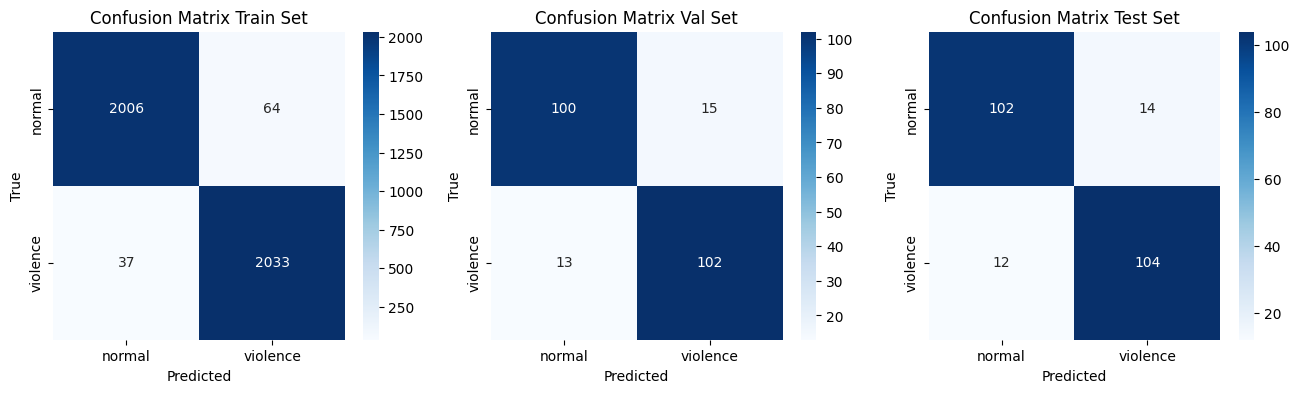

In [ ]:
evaluation_class = EvaluationClass(model_with_lora_all, device, class_names, tokenizer)
evaluation_class.plot_all_matrixes(pytorch_train, pytorch_val, pytorch_test)

In [ ]:
def collect_misclassified_examples(model, pytorch_dataset):
    misclassified_examples = []
    evaluation_class = EvaluationClass(model, device, class_names, tokenizer)

    for i in range(len(pytorch_dataset)):
        item = pytorch_dataset[i]
        predicted_label = evaluation_class.classify_input(item['input_ids'], item['attention_mask'])
        true_label = item['labels'].item()
        if predicted_label != true_label:
            misclassified_examples.append({
                'text': pytorch_dataset.texts[i],
                'label': true_label
            })

    random.shuffle(misclassified_examples)
    return misclassified_examples

In [ ]:
misclassified = collect_misclassified_examples(model_with_lora_all, pytorch_test)
print(misclassified)

[{'text': 'Bolje se ne sukobljavaj s njim, deo je grupe i mogli bi da te povrede.', 'label': 0}, {'text': 'Moj ti je savet da se ubiješ.', 'label': 1}, {'text': 'Ovako: Uhvatićemo je i prebaciti preko granice gde ćemo je prodati', 'label': 1}, {'text': 'Naći ću te čim te vidim na mapi, baš da isprobam novi item.', 'label': 0}, {'text': 'Ubij se, ne vredi ti ništa što radiš.', 'label': 1}, {'text': 'Izbrisaću ti nalog ovaj onda.', 'label': 0}, {'text': 'Učiteljice, Marko govori da će me napasti.', 'label': 0}, {'text': 'Neka se bore dok jedan od njih ne umre.', 'label': 1}, {'text': 'Kada te pronađem, reći ću ti par stvari.', 'label': 0}, {'text': 'Ajde da mu uzmemo poklon za njegov rođendan.', 'label': 0}, {'text': 'Tvoj dug će uskoro biti naplaćen tvojom krvlju!', 'label': 1}, {'text': 'Skratiću ti kosu 2 cm samo', 'label': 0}, {'text': 'Perica, čini se da ti je nos polomljen.', 'label': 0}, {'text': 'Napraviću logorsku vatru da nam ne bude hladno.', 'label': 0}, {'text': 'Svi belci ć

In [ ]:
fina_name = 'BestModel'
final_path = loader_class.map_name_to_path(fina_name)
model_with_lora_all.save_pretrained(final_path)

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


## **Experiment 5** Mining hard examples

In [ ]:
def collect_all_plus_misclassified_examples(model, pytorch_dataset):
    all_plus_misclassified_examples = []
    evaluation_class = EvaluationClass(model, device, class_names, tokenizer)

    for i in range(len(pytorch_dataset)):
        item = pytorch_dataset[i]
        predicted_label = evaluation_class.classify_input(item['input_ids'], item['attention_mask'])
        true_label = item['labels'].item()
        if predicted_label != true_label:
            all_plus_misclassified_examples.append({
                'text': pytorch_dataset.texts[i],
                'label': true_label
            })
        all_plus_misclassified_examples.append({
                'text': pytorch_dataset.texts[i],
                'label': true_label
            })
    random.shuffle(all_plus_misclassified_examples)
    return SentimentDataset(all_plus_misclassified_examples, tokenizer, max_length)

In [ ]:
early_stopping_patience = 3
current_val_f1 = 0
best_eval_f1 = 0
best_eval_iteration = -1
best_model_so_far = None
iteration = -1

#model
model_with_lora_layers_all, model_info_all = model_class.get_model_with_lora(quantized = True, lora_rank = 16, scaling_factor = 48, dropout = 0.1, chosen_layers = list(range(12)))

trainer_class = GetTrainer(num_epochs = 1, lr = 0.00048569487626740564, weight_decay=0.008452656442872837)

#train set init
current_train_set = pytorch_train
#new_prediction = evaluation_class.classify_input(item['input_ids'], item['attention_mask'])

while(iteration < 15):
    iteration += 1
    print("current iteration: ", iteration, "current train set length: ", len(current_train_set))
    #trainer
    trainer, training_hyperparameters_info = trainer_class.get_trainer(model_with_lora_layers_all, current_train_set, pytorch_val)
    trainer.train()

    #evaluation`
    current_eval_f1 = trainer.evaluate(eval_dataset = pytorch_val)['eval_f1_score']
    print("train set: eval_f1: ", trainer.evaluate(eval_dataset = pytorch_train)['eval_f1_score'])
    print("val set: eval_f1: ", trainer.evaluate(eval_dataset = pytorch_val)['eval_f1_score'])

    if current_eval_f1 <= best_eval_f1 and iteration - best_eval_iteration >= early_stopping_patience:
        break
    elif current_eval_f1 > best_eval_f1:
        best_eval_f1 = current_eval_f1
        best_eval_iteration = iteration
        best_model_so_far = trainer.model

    print("best f1 so far: ", best_eval_f1, "is from iteration: ", best_eval_iteration)

    #new train dataset
    current_train_set = collect_all_plus_misclassified_examples(model_with_lora_layers_all, pytorch_train)

print("test set: ", trainer.evaluate(eval_dataset = pytorch_test))

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self

current iteration:  0 current train set length:  4140


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.249000,0.479484,0.782609,0.785720,0.782609,0.782015


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.822711010393941
val set: eval_f1:  0.7820153157934642
best f1 so far:  0.7820153157934642 is from iteration:  0
current iteration:  1 current train set length:  4873


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.232400,0.411897,0.817391,0.817776,0.817391,0.817336


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.8889583031784375
val set: eval_f1:  0.8173360562741093
best f1 so far:  0.8173360562741093 is from iteration:  1
current iteration:  2 current train set length:  4599


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.086900,0.391593,0.813043,0.814208,0.813043,0.812870


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9357421788841952
val set: eval_f1:  0.8128701443681292
best f1 so far:  0.8173360562741093 is from iteration:  1
current iteration:  3 current train set length:  4404


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.091300,0.335428,0.843478,0.843582,0.843478,0.843466


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9548301562414031
val set: eval_f1:  0.8434664246823956
best f1 so far:  0.8434664246823956 is from iteration:  3
current iteration:  4 current train set length:  4325


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.855500,0.418190,0.847826,0.848485,0.847826,0.847754


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9603693722068685
val set: eval_f1:  0.8477541371158392
best f1 so far:  0.8477541371158392 is from iteration:  4
current iteration:  5 current train set length:  4305


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.231400,0.373344,0.847826,0.849120,0.847826,0.847685


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9714973450732625
val set: eval_f1:  0.8476850012298727
best f1 so far:  0.8477541371158392 is from iteration:  4
current iteration:  6 current train set length:  4258


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,2.671900,0.442655,0.856522,0.857848,0.856522,0.856389


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9726977300457857
val set: eval_f1:  0.8563887154453086
best f1 so far:  0.8563887154453086 is from iteration:  6
current iteration:  7 current train set length:  4253


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.106900,0.487504,0.865217,0.873377,0.865217,0.864477


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.969788782431888
val set: eval_f1:  0.8644770105111099
best f1 so far:  0.8644770105111099 is from iteration:  7
current iteration:  8 current train set length:  4266


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.042700,0.461795,0.847826,0.848063,0.847826,0.847800


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9842990323104444
val set: eval_f1:  0.847800192849445
best f1 so far:  0.8644770105111099 is from iteration:  7
current iteration:  9 current train set length:  4206


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.018400,0.550883,0.869565,0.869677,0.869565,0.869555


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9893719583531996
val set: eval_f1:  0.8695553539019965
best f1 so far:  0.8695553539019965 is from iteration:  9
current iteration:  10 current train set length:  4184


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.005600,0.415274,0.891304,0.892045,0.891304,0.891253


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9847825864993736
val set: eval_f1:  0.8912529550827423
best f1 so far:  0.8912529550827423 is from iteration:  10
current iteration:  11 current train set length:  4204


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.084000,0.535292,0.882609,0.884032,0.882609,0.882500


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9891303276053913
val set: eval_f1:  0.882499858091616
best f1 so far:  0.8912529550827423 is from iteration:  10
current iteration:  12 current train set length:  4185


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.293000,0.427611,0.895652,0.896732,0.895652,0.895581


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9917874223638361
val set: eval_f1:  0.8955811138014529
best f1 so far:  0.8955811138014529 is from iteration:  12
current iteration:  13 current train set length:  4174


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.003900,0.454300,0.882609,0.884967,0.882609,0.882429


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9922705151659633
val set: eval_f1:  0.8824286715007857
best f1 so far:  0.8955811138014529 is from iteration:  12
current iteration:  14 current train set length:  4174


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.028100,0.469765,0.882609,0.886142,0.882609,0.882340


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9946859704953506
val set: eval_f1:  0.8823395668731882
best f1 so far:  0.8955811138014529 is from iteration:  12
current iteration:  15 current train set length:  4161


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.000900,0.547061,0.886957,0.887074,0.886957,0.886948


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


train set: eval_f1:  0.9949275359359341
val set: eval_f1:  0.8869479733817303
test set:  {'eval_loss': 0.6842995285987854, 'eval_accuracy': 0.8663793103448276, 'eval_precision': 0.8677183560826434, 'eval_recall': 0.8663793103448276, 'eval_f1_score': 0.8662575546257555, 'eval_runtime': 0.641, 'eval_samples_per_second': 361.943, 'eval_steps_per_second': 23.402, 'epoch': 1.0}


Train Set: {'accuracy': 0.9946859903381643, 'precision': 0.9946859903381643, 'recall': 0.9946859903381643, 'f1_score': 0.9946859903381643}
Val Set: {'accuracy': 0.8869565217391304, 'precision': 0.8870735950381968, 'recall': 0.8869565217391304, 'f1_score': 0.8859649122807017}
Test Set: {'accuracy': 0.8663793103448276, 'precision': 0.8677183560826434, 'recall': 0.8663793103448276, 'f1_score': 0.8622222222222222}


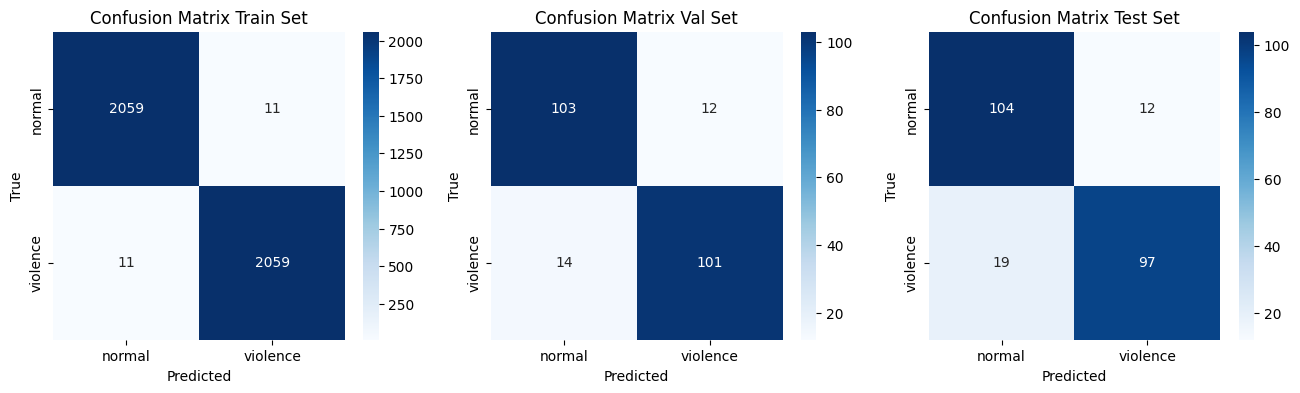

In [ ]:
evaluation_class = EvaluationClass(best_model_so_far, device, class_names, tokenizer)
evaluation_class.get_metrics(pytorch_test)

evaluation_class.plot_all_matrixes(pytorch_train, pytorch_val, pytorch_test)